## TODO

- Add Tau to table
- relative entropy per gene per tissue relative to isoform fractions in other tissues (KL divergence)?
- Should be doing the isoform ratios at the sample level before aggregating
- map GC grp to our isoform names

In [10]:
from pathlib import Path

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../../data/internal/GTEx-protein-gencode/protein.GC30-basic.txt',
                 sep='\t')
metadata = pd.read_csv('../../data/internal/GTEx-protein-gencode/SRA-filtered.txt',
                       sep='\t')
if metadata['UID'].duplicated().any():
    raise UserWarning('Unexpected duplicates')
metadata = metadata.set_index('UID')
if df.columns.duplicated().any():
    raise UserWarning('Unexpected duplicates')
if df['UID'].duplicated().any():
    raise UserWarning('Unexpected duplicates')
df = df.set_index('UID')
df = (df + 1.).apply(np.log2)

In [3]:
genes = pd.Series(index=df.index,
                  data=df.index.str.replace('\|.*', '', regex=True)
                               .str.extract('GC grp\: (.*)-2[0-9]{2}', expand=False).values)
genes.nunique()

1625

In [4]:
genes.loc[genes.isnull()]

UID
GC grp: AC006213    NaN
GC grp: AC118549    NaN
GC grp: AC008554    NaN
GC grp: AC092072    NaN
GC grp: AC073611    NaN
GC grp: AC008770    NaN
GC grp: AC092835    NaN
GC grp: AC139768    NaN
GC grp: AL590327    NaN
GC grp: AC138696    NaN
dtype: object

In [5]:
means = df.groupby(df.columns.map(metadata['body_site']), axis=1).mean()
medians = df.groupby(df.columns.map(metadata['body_site']), axis=1).median()
tip_score = (means.sub(means.median(axis=1), axis=0)
                    .div(means.quantile(q=0.75, axis=1) -
                         means.quantile(q=0.25, axis=1), axis=0))
f_i = means.div(means.sum(axis=1), axis=0)
q_i = 1. / f_i.shape[1]  # this is relative entropy
entropy_per_isoform = (f_i.mul((f_i / q_i).apply(np.log2))).sum(axis=1)
# gene-level tissue-speceficity metrics
gene_means = df.groupby(genes).sum().groupby(df.columns.map(metadata['body_site']), axis=1).mean()
gene_medians = df.groupby(genes).sum().groupby(df.columns.map(metadata['body_site']), axis=1).mean()
gene_tip = (gene_means.sub(gene_means.median(axis=1), axis=0)
                    .div(gene_means.quantile(q=0.75, axis=1) -
                         gene_means.quantile(q=0.25, axis=1), axis=0))
f_i = gene_means.div(gene_means.sum(axis=1), axis=0)
q_i = 1. / f_i.shape[1]  # this is relative entropy
gene_entropy_per_isoform = (f_i.mul((f_i / q_i).apply(np.log2))).sum(axis=1)
iso = genes.to_frame(name='gene').copy()
iso['mean_logTPM'] = means.mean(axis=1)
iso['median_logTPM'] = medians.median(axis=1)
iso['max_logTPM'] = means.max(axis=1)
iso['max_TiP_score'] = tip_score.max(axis=1)
iso['tissue_with_max_TiP_score'] = tip_score.idxmax(axis=1)
iso['entropy'] = entropy_per_isoform
iso['gene_max_TiP_score'] = iso['gene'].map(gene_tip.max(axis=1))
iso['gene_entropy'] = iso['gene'].map(gene_entropy_per_isoform)
iso.head()

gene  mean_logTPM  median_logTPM  max_logTPM  \
UID                                                                  
GC grp: KCNIP3-201  KCNIP3     1.577801       1.101364    5.008550   
GC grp: KCNIP3-202  KCNIP3     1.781531       1.637533    3.729617   
GC grp: KCNIP3-205  KCNIP3     0.784612       0.618098    1.876189   
GC grp: TFDP2-209    TFDP2     0.030298       0.000000    0.214965   
GC grp: NFATC2-206  NFATC2     0.037247       0.000000    0.152472   

                    max_TiP_score     tissue_with_max_TiP_score   entropy  \
UID                                                                         
GC grp: KCNIP3-201       2.180588  Brain - Frontal Cortex (BA9)  0.498635   
GC grp: KCNIP3-202       1.089647                        Testis  0.283124   
GC grp: KCNIP3-205       1.131689           Cervix - Endocervix  0.428055   
GC grp: TFDP2-209        5.665579             Muscle - Skeletal  0.964005   
GC grp: NFATC2-206       2.261455        Adipose - Subcutaneous  0.784859   

                    gene_max_TiP_score  gene_entropy  
UID                                                   
GC grp: KCNIP3-201            1.817019      0.150422  
GC grp: KCNIP3-202            1.817019      0.150422  
GC grp: KCNIP3-205            1.817019      0.150422  
GC grp: TFDP2-209             2.735584      0.082454  
GC grp: NFATC2-206            1.716182      0.201238

1625 total TF genes in dataset
1562 genes with TPM > 1
3193 isoforms with TPM > 1
814 genes with ≥ 2 isoforms with TPM > 1


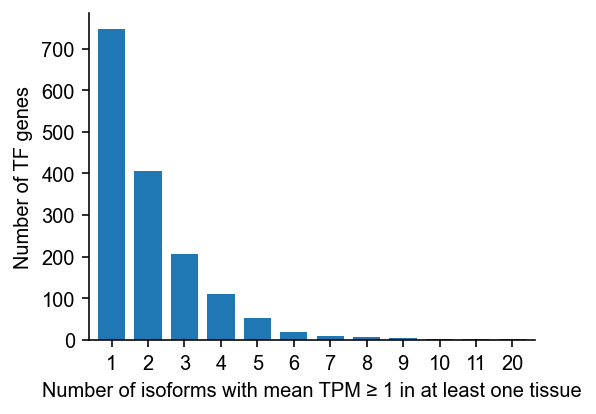

In [9]:
print(genes.nunique(), 'total TF genes in dataset')
print(genes[means.max(axis=1) > 1.].nunique(), 'genes with TPM > 1')
print(genes[means.max(axis=1) > 1.].shape[0], 'isoforms with TPM > 1')
print((genes[means.max(axis=1) > 1.].value_counts() >= 2).sum(), 'genes with ≥ 2 isoforms with TPM > 1')
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 3)
genes[means.max(axis=1) > 1.].value_counts().value_counts().sort_index().plot.bar(rot=0,
                                                                     width=0.75,
                                                                     ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Number of TF genes')
ax.set_xlabel('Number of isoforms with mean TPM ≥ 1 in at least one tissue')
plt.savefig('../../figures/number_of_isoforms_gt_1TPM_per_tf_gene_GTEx.pdf',
            bbox_inches='tight')
# NOTE: add break onto x-axis in Illustrator

In [7]:
def number_dominant_isoforms_across_all_tissues(rows):
    n_isoforms = rows.shape[0]
    if n_isoforms == 0:
        return 0
    if n_isoforms == 1:
        if (rows >= 1.).any().any():
            return 1
        else:
            return 0
    dom_per_tissue = [dominant_isoform_in_tissue(rows[c]) for c in rows.columns]
    return len({iso_id for iso_id in dom_per_tissue if iso_id is not None})


def dominant_isoform_in_tissue(column):
    """Dominant isoform: TPM > 1 and 2-fold more expressed than second most expressed"""
    isoforms_ordered = column.sort_values(ascending=False)
    if isoforms_ordered.iloc[1] == 0:
        fold_change_1st_over_2nd = np.inf
    else:
        fold_change_1st_over_2nd = (2**isoforms_ordered.iloc[0] - 1) / (2**isoforms_ordered.iloc[1] - 1)
    if (isoforms_ordered.iloc[0] >= 1.) and fold_change_1st_over_2nd >= 2:
        return isoforms_ordered.index[0]
    else:
        return None
    

n_dom_per_iso = means.groupby(genes).apply(number_dominant_isoforms_across_all_tissues)
n_dom = n_dom_per_iso.value_counts().sort_index()
print(n_dom)
n_dom = n_dom[n_dom.index > 0]

0     110
1    1404
2     110
4       1
dtype: int64


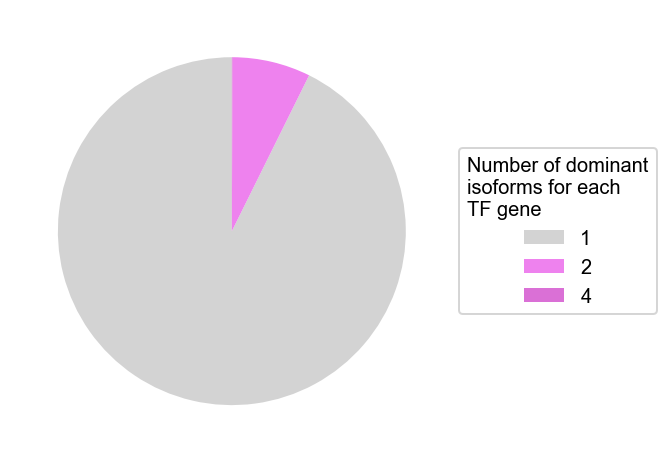

In [38]:
# make it look nicer
fig, ax = plt.subplots(1, 1)
n_dom.plot.pie(startangle=90,
               label='',
               labels=None,
               colors=['lightgrey', 'violet', 'orchid', 'magenta', 'purple'])
ax.legend(n_dom.index,
          loc='center left',
          bbox_to_anchor=[1, 0.5],
          title='Number of dominant\nisoforms for each\nTF gene')
plt.savefig('../../figures/dominant_isoforms_pie.pdf',
            bbox_inches='tight')

In [40]:
n_dom.head()

1    1404
2     110
4       1
dtype: int64

In [37]:
n_dom_per_iso.sort_values().tail()

GLMP      2
MECP2     2
ZNF141    2
CASZ1     2
FOXM1     4
dtype: int64

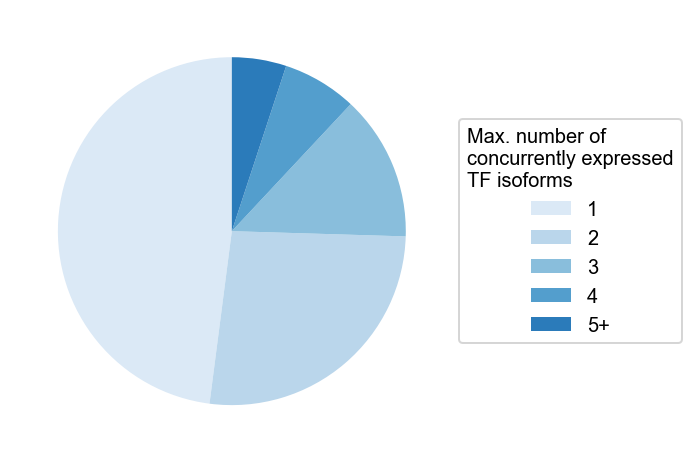

In [39]:
fig, ax = plt.subplots(1, 1)
coexp_iso = (means >= 1.).groupby(genes).sum().max(axis=1).value_counts().sort_index()
data_to_plot = {}
for i in range(1, 5):
    data_to_plot[str(i)] = coexp_iso[i]
data_to_plot['5+'] = coexp_iso.loc[coexp_iso.index >= 5].sum()
ax.pie(data_to_plot.values(),
       colors=sns.color_palette("Blues"),
       startangle=90)
ax.legend(data_to_plot.keys(),
          loc='center left',
          bbox_to_anchor=[1, 0.5],
          title='Max. number of\nconcurrently expressed\nTF isoforms')
plt.savefig('../../figures/coexpressed_isoforms_pie.pdf',
            bbox_inches='tight')

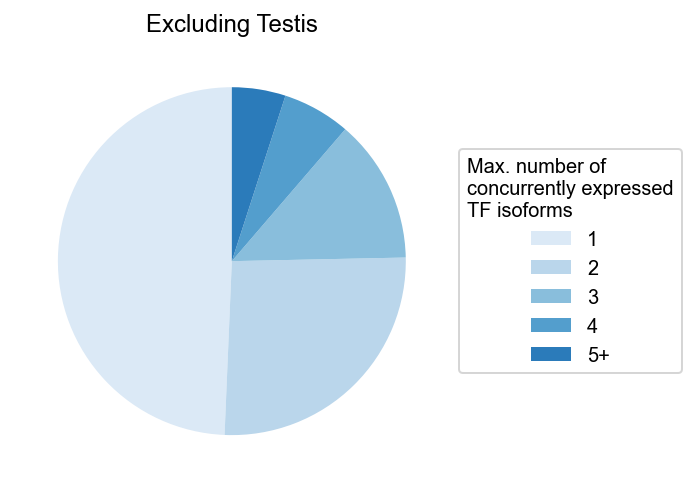

In [66]:
fig, ax = plt.subplots(1, 1)
coexp_iso = (means.loc[:, filter(lambda x: x != 'Testis', means.columns)] >= 1.).groupby(genes).sum().max(axis=1).value_counts().sort_index()
data_to_plot = {}
for i in range(1, 5):
    data_to_plot[str(i)] = coexp_iso[i]
data_to_plot['5+'] = coexp_iso.loc[coexp_iso.index >= 5].sum()
ax.pie(data_to_plot.values(),
       colors=sns.color_palette("Blues"),
       startangle=90)
ax.legend(data_to_plot.keys(),
          loc='center left',
          bbox_to_anchor=[1, 0.5],
          title='Max. number of\nconcurrently expressed\nTF isoforms')
ax.set_title('Excluding Testis')
plt.savefig('../../figures/coexpressed_isoforms_pie_excluding_testis.pdf',
            bbox_inches='tight')

In [10]:
iso.sort_values('max_TiP_score', ascending=False).head()

gene   mean_logTPM  median_logTPM    max_logTPM  \
UID                                                                   
GC grp: TP53-221    TP53  1.948490e-08            0.0  9.828253e-07   
GC grp: PAX5-207    PAX5  2.384453e-03            0.0  5.946602e-02   
GC grp: IKZF3-210  IKZF3  5.197684e-04            0.0  7.772308e-03   
GC grp: PAX5-206    PAX5  3.983880e-03            0.0  9.518032e-02   
GC grp: IKZF3-212  IKZF3  5.462950e-05            0.0  2.786104e-03   

                   max_TiP_score           tissue_with_max_TiP_score  \
UID                                                                    
GC grp: TP53-221             inf  Brain - Spinal cord (cervical c-1)   
GC grp: PAX5-207             inf              Adipose - Subcutaneous   
GC grp: IKZF3-210            inf                      Artery - Aorta   
GC grp: PAX5-206             inf                   Artery - Coronary   
GC grp: IKZF3-212            inf                  Colon - Transverse   

                    entropy  gene_max_TiP_score  gene_entropy  
UID                                                            
GC grp: TP53-221   5.577190            0.703721      0.130711  
GC grp: PAX5-207   3.445139           67.896294      1.909189  
GC grp: IKZF3-210  3.409749            8.532178      0.392771  
GC grp: PAX5-206   3.653918           67.896294      1.909189  
GC grp: IKZF3-212  5.672425            8.532178      0.392771

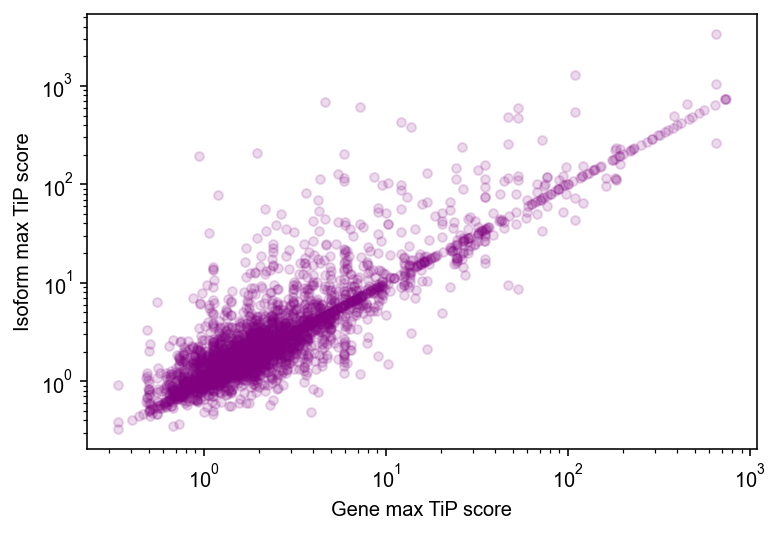

In [11]:
fig, ax = plt.subplots(1, 1)
(iso.loc[iso['max_logTPM'] > 1, :]
    .plot.scatter(x='gene_max_TiP_score',
                  y='max_TiP_score',
                  alpha=0.15,
                  color='purple',
                  ax=ax))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Isoform max TiP score')
ax.set_xlabel('Gene max TiP score')
plt.savefig('../../figures/isoform_vs_gene_TiP_score_scatter.pdf',
            bbox_inches='tight')

In [12]:
# theres a problem with infs in the TiP score
# a pseudo count wont help because it's in the IQR that's the problem 
# inspect inf values
(iso.loc[(iso['max_logTPM'] > 1) & 
         (iso['max_TiP_score'] == np.inf), :]
    .sort_values('max_TiP_score', ascending=False).head(60))

gene  mean_logTPM  median_logTPM  max_logTPM  max_TiP_score  \
UID                                                                             
GC grp: SPIB-206  SPIB     0.040626            0.0    1.092764            inf   

                 tissue_with_max_TiP_score   entropy  gene_max_TiP_score  \
UID                                                                        
GC grp: SPIB-206             Adrenal Gland  3.859802           16.789468   

                  gene_entropy  
UID                             
GC grp: SPIB-206      0.727254

In [13]:
iso['TiP_diff'] = iso['max_TiP_score'] - iso['gene_max_TiP_score']
(iso.loc[(iso['max_logTPM'] > 1), :]
    .sort_values('TiP_diff', ascending=False).head(30))

gene  mean_logTPM  \
UID                                                                      
GC grp: SPIB-206                                     SPIB     0.040626   
GC grp: LHX3-201                                     LHX3     0.095715   
GC grp: PAX2-205                                     PAX2     0.100200   
GC grp: PGR-207                                       PGR     0.043924   
GC grp: ZSCAN29-204                               ZSCAN29     0.042709   
GC grp: HNF4A-204                                   HNF4A     0.153605   
GC grp: HNF1A-201                                   HNF1A     0.173192   
GC grp: PAX2-203                                     PAX2     0.088933   
GC grp: HNF4A-202                                   HNF4A     0.094163   
GC grp: TP63-207                                     TP63     0.059898   
GC grp: LHX3-203                                     LHX3     0.075698   
GC grp: CTCFL-202|CTCFL-222|CTCFL-201|CTCFL-216     CTCFL     0.078628   
GC grp: CDX1-201                                     CDX1     0.125802   
GC grp: HNF1A-208                                   HNF1A     0.100626   
GC grp: DMRTC2-201                                 DMRTC2     0.126642   
GC grp: TCF4-203                                     TCF4     0.048925   
GC grp: ZNF479-202|ZNF479-201                      ZNF479     0.040008   
GC grp: CREM-214                                     CREM     0.117583   
GC grp: GTF2IRD2-208                             GTF2IRD2     0.054403   
GC grp: NR1I3-235                                   NR1I3     0.095158   
GC grp: BNC1-202                                     BNC1     0.123831   
GC grp: SOX5-214                                     SOX5     0.068387   
GC grp: DMRT1-201                                   DMRT1     0.111777   
GC grp: SPIB-201                                     SPIB     0.215835   
GC grp: NR6A1-203                                   NR6A1     0.047839   
GC grp: CREM-202                                     CREM     0.184454   
GC grp: TP73-207                                     TP73     0.102826   
GC grp: CREB3L3-202                               CREB3L3     0.058846   
GC grp: CREM-208                                     CREM     0.091571   
GC grp: SOX6-211                                     SOX6     0.073986   

                                                 median_logTPM  max_logTPM  \
UID                                                                          
GC grp: SPIB-206                                           0.0    1.092764   
GC grp: LHX3-201                                           0.0    4.778114   
GC grp: PAX2-205                                           0.0    2.827334   
GC grp: PGR-207                                            0.0    2.116144   
GC grp: ZSCAN29-204                                        0.0    2.070845   
GC grp: HNF4A-204                                          0.0    2.313671   
GC grp: HNF1A-201                                          0.0    1.616072   
GC grp: PAX2-203                                           0.0    2.373144   
GC grp: HNF4A-202                                          0.0    1.135011   
GC grp: TP63-207                                           0.0    2.644436   
GC grp: LHX3-203                                           0.0    3.636637   
GC grp: CTCFL-202|CTCFL-222|CTCFL-201|CTCFL-216            0.0    3.059432   
GC grp: CDX1-201                                           0.0    2.843940   
GC grp: HNF1A-208                                          0.0    1.389966   
GC grp: DMRTC2-201                                         0.0    5.474436   
GC grp: TCF4-203                                           0.0    1.991063   
GC grp: ZNF479-202|ZNF479-201                              0.0    1.915753   
GC grp: CREM-214                                           0.0    5.156756   
GC grp: GTF2IRD2-208                                       0.0    2.331151   
GC grp: NR1I3-235                             

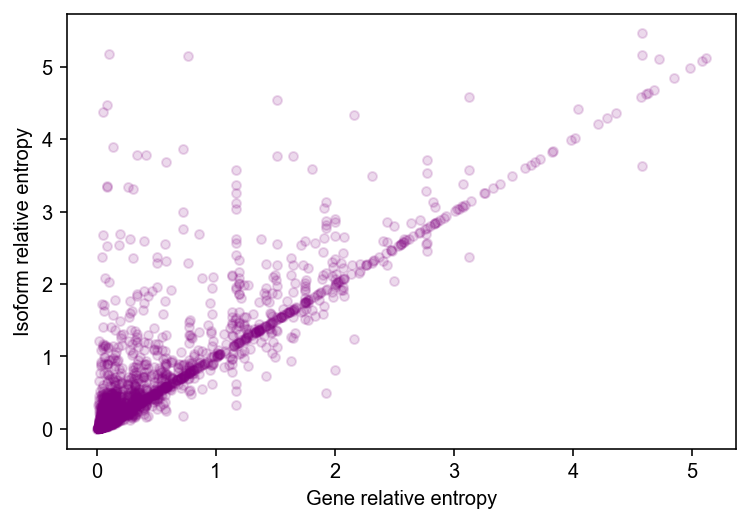

In [14]:
fig, ax = plt.subplots(1, 1)
(iso.loc[iso['max_logTPM'] > 1, :]
    .plot.scatter(x='gene_entropy',
                  y='entropy',
                  alpha=0.15,
                  color='purple',
                  ax=ax))
ax.set_ylabel('Isoform relative entropy')
ax.set_xlabel('Gene relative entropy')
plt.savefig('../../figures/isoform_vs_gene_entropy_scatter.pdf',
            bbox_inches='tight')

In [15]:
iso['entropy_diff'] = iso['entropy'] - iso['gene_entropy']
(iso.loc[(iso['max_logTPM'] > 1), :]
    .sort_values('entropy_diff', ascending=False).head())

gene  mean_logTPM  median_logTPM  max_logTPM  \
UID                                                                      
GC grp: ZSCAN29-204    ZSCAN29     0.042709            0.0    2.070845   
GC grp: CREM-214          CREM     0.117583            0.0    5.156756   
GC grp: PGR-207            PGR     0.043924            0.0    2.116144   
GC grp: GTF2IRD2-208  GTF2IRD2     0.054403            0.0    2.331151   
GC grp: TCF4-203          TCF4     0.048925            0.0    1.991063   

                      max_TiP_score tissue_with_max_TiP_score   entropy  \
UID                                                                       
GC grp: ZSCAN29-204      603.444588                    Testis  5.174066   
GC grp: CREM-214         201.344347                    Testis  4.467077   
GC grp: PGR-207          679.326984                    Testis  5.143680   
GC grp: GTF2IRD2-208     195.024628                    Testis  4.367963   
GC grp: TCF4-203         209.197909                    Testis  3.886510   

                      gene_max_TiP_score  gene_entropy    TiP_diff  \
UID                                                                  
GC grp: ZSCAN29-204             7.206938      0.106102  596.237650   
GC grp: CREM-214                5.912423      0.087861  195.431924   
GC grp: PGR-207                 4.627856      0.767239  674.699128   
GC grp: GTF2IRD2-208            0.942863      0.055046  194.081765   
GC grp: TCF4-203                1.951922      0.132913  207.245987   

                      entropy_diff  
UID                                 
GC grp: ZSCAN29-204       5.067964  
GC grp: CREM-214          4.379216  
GC grp: PGR-207           4.376441  
GC grp: GTF2IRD2-208      4.312917  
GC grp: TCF4-203          3.753597

In [16]:
# entropy per gene per tissue
entropy_per_tissue = pd.DataFrame(data=[means[c].groupby(genes).apply(stats.entropy, base=2) for c in means.columns]).T

Text(0, 0.5, 'Entropy per TF gene')

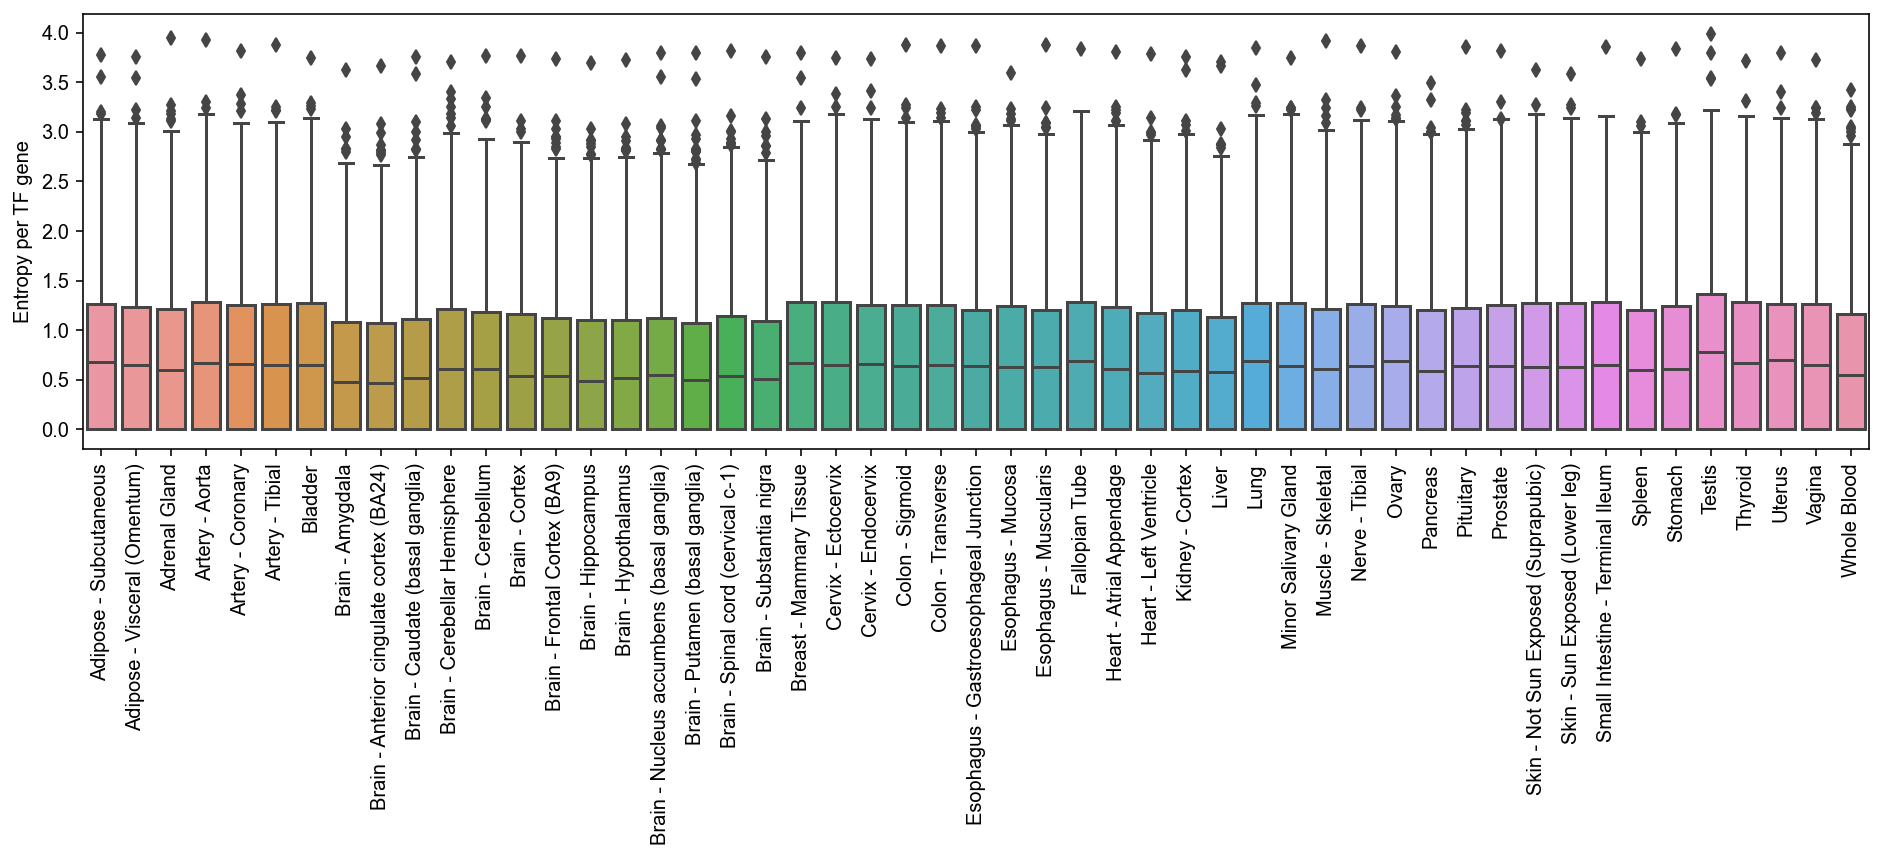

In [17]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 4)
sns.boxplot(data=entropy_per_tissue,
            ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Entropy per TF gene')

Text(0, 0.5, 'Entropy per TF gene')

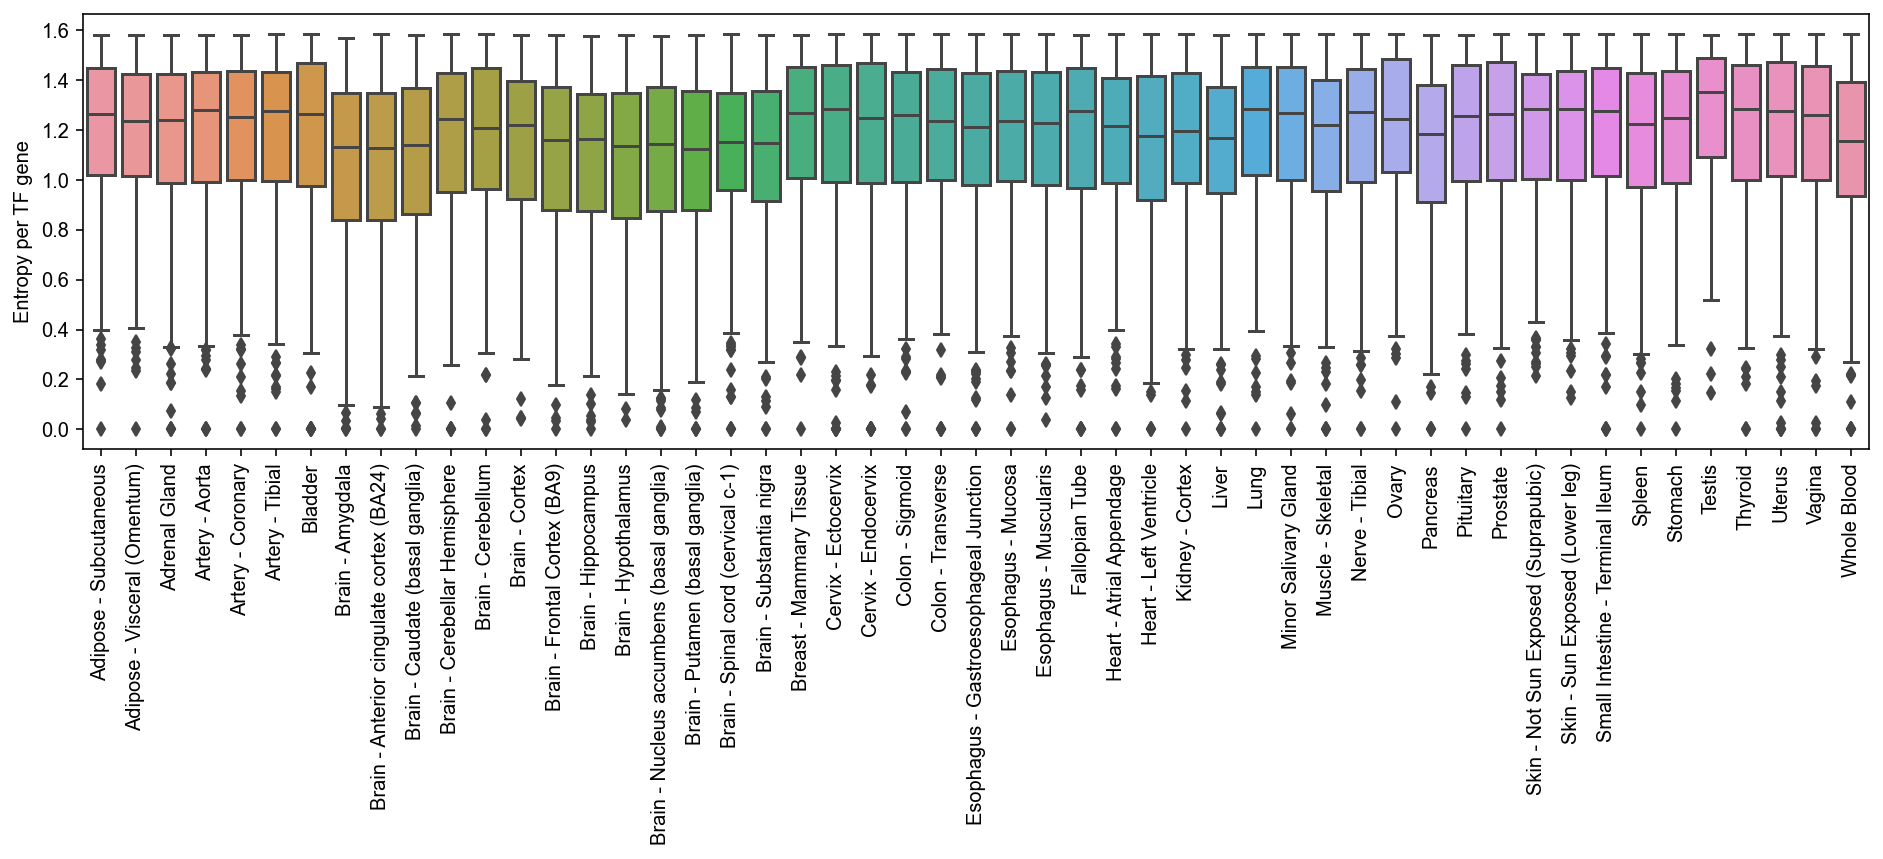

In [18]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 4)
sns.boxplot(data=entropy_per_tissue.loc[genes.value_counts() == 3, :],
            ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Entropy per TF gene')

In [19]:
genes.value_counts().value_counts().sort_index()

1     641
2     422
3     216
4     156
5      77
6      31
7      34
8      13
9       6
10      6
11      6
12      4
13      3
14      2
15      3
18      1
21      1
23      2
25      1
dtype: int64

In [20]:
entropy_per_tissue.idxmax().value_counts()

CREM    51
dtype: int64

(SpearmanrResult(correlation=0.9555615576941779, pvalue=0.0),
 (0.8172842933953335, 0.0))

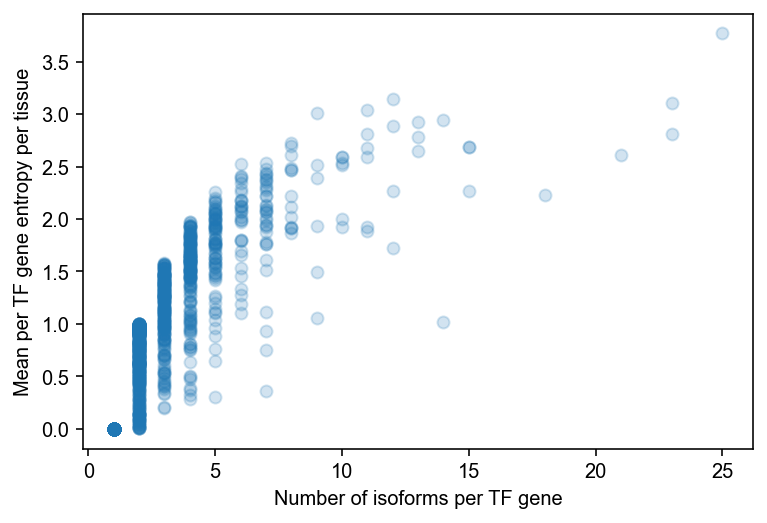

In [21]:
# looks like the entropy per tissue is mainly measuring the number of isoforms
fig, ax = plt.subplots(1, 1)
x = genes.value_counts()[entropy_per_tissue.index].values
y = entropy_per_tissue.mean(axis=1).values
ax.scatter(x, y, alpha=0.2)
ax.set_xlabel('Number of isoforms per TF gene')
ax.set_ylabel('Mean per TF gene entropy per tissue')
(stats.spearmanr(x, y), stats.pearsonr(x, y))

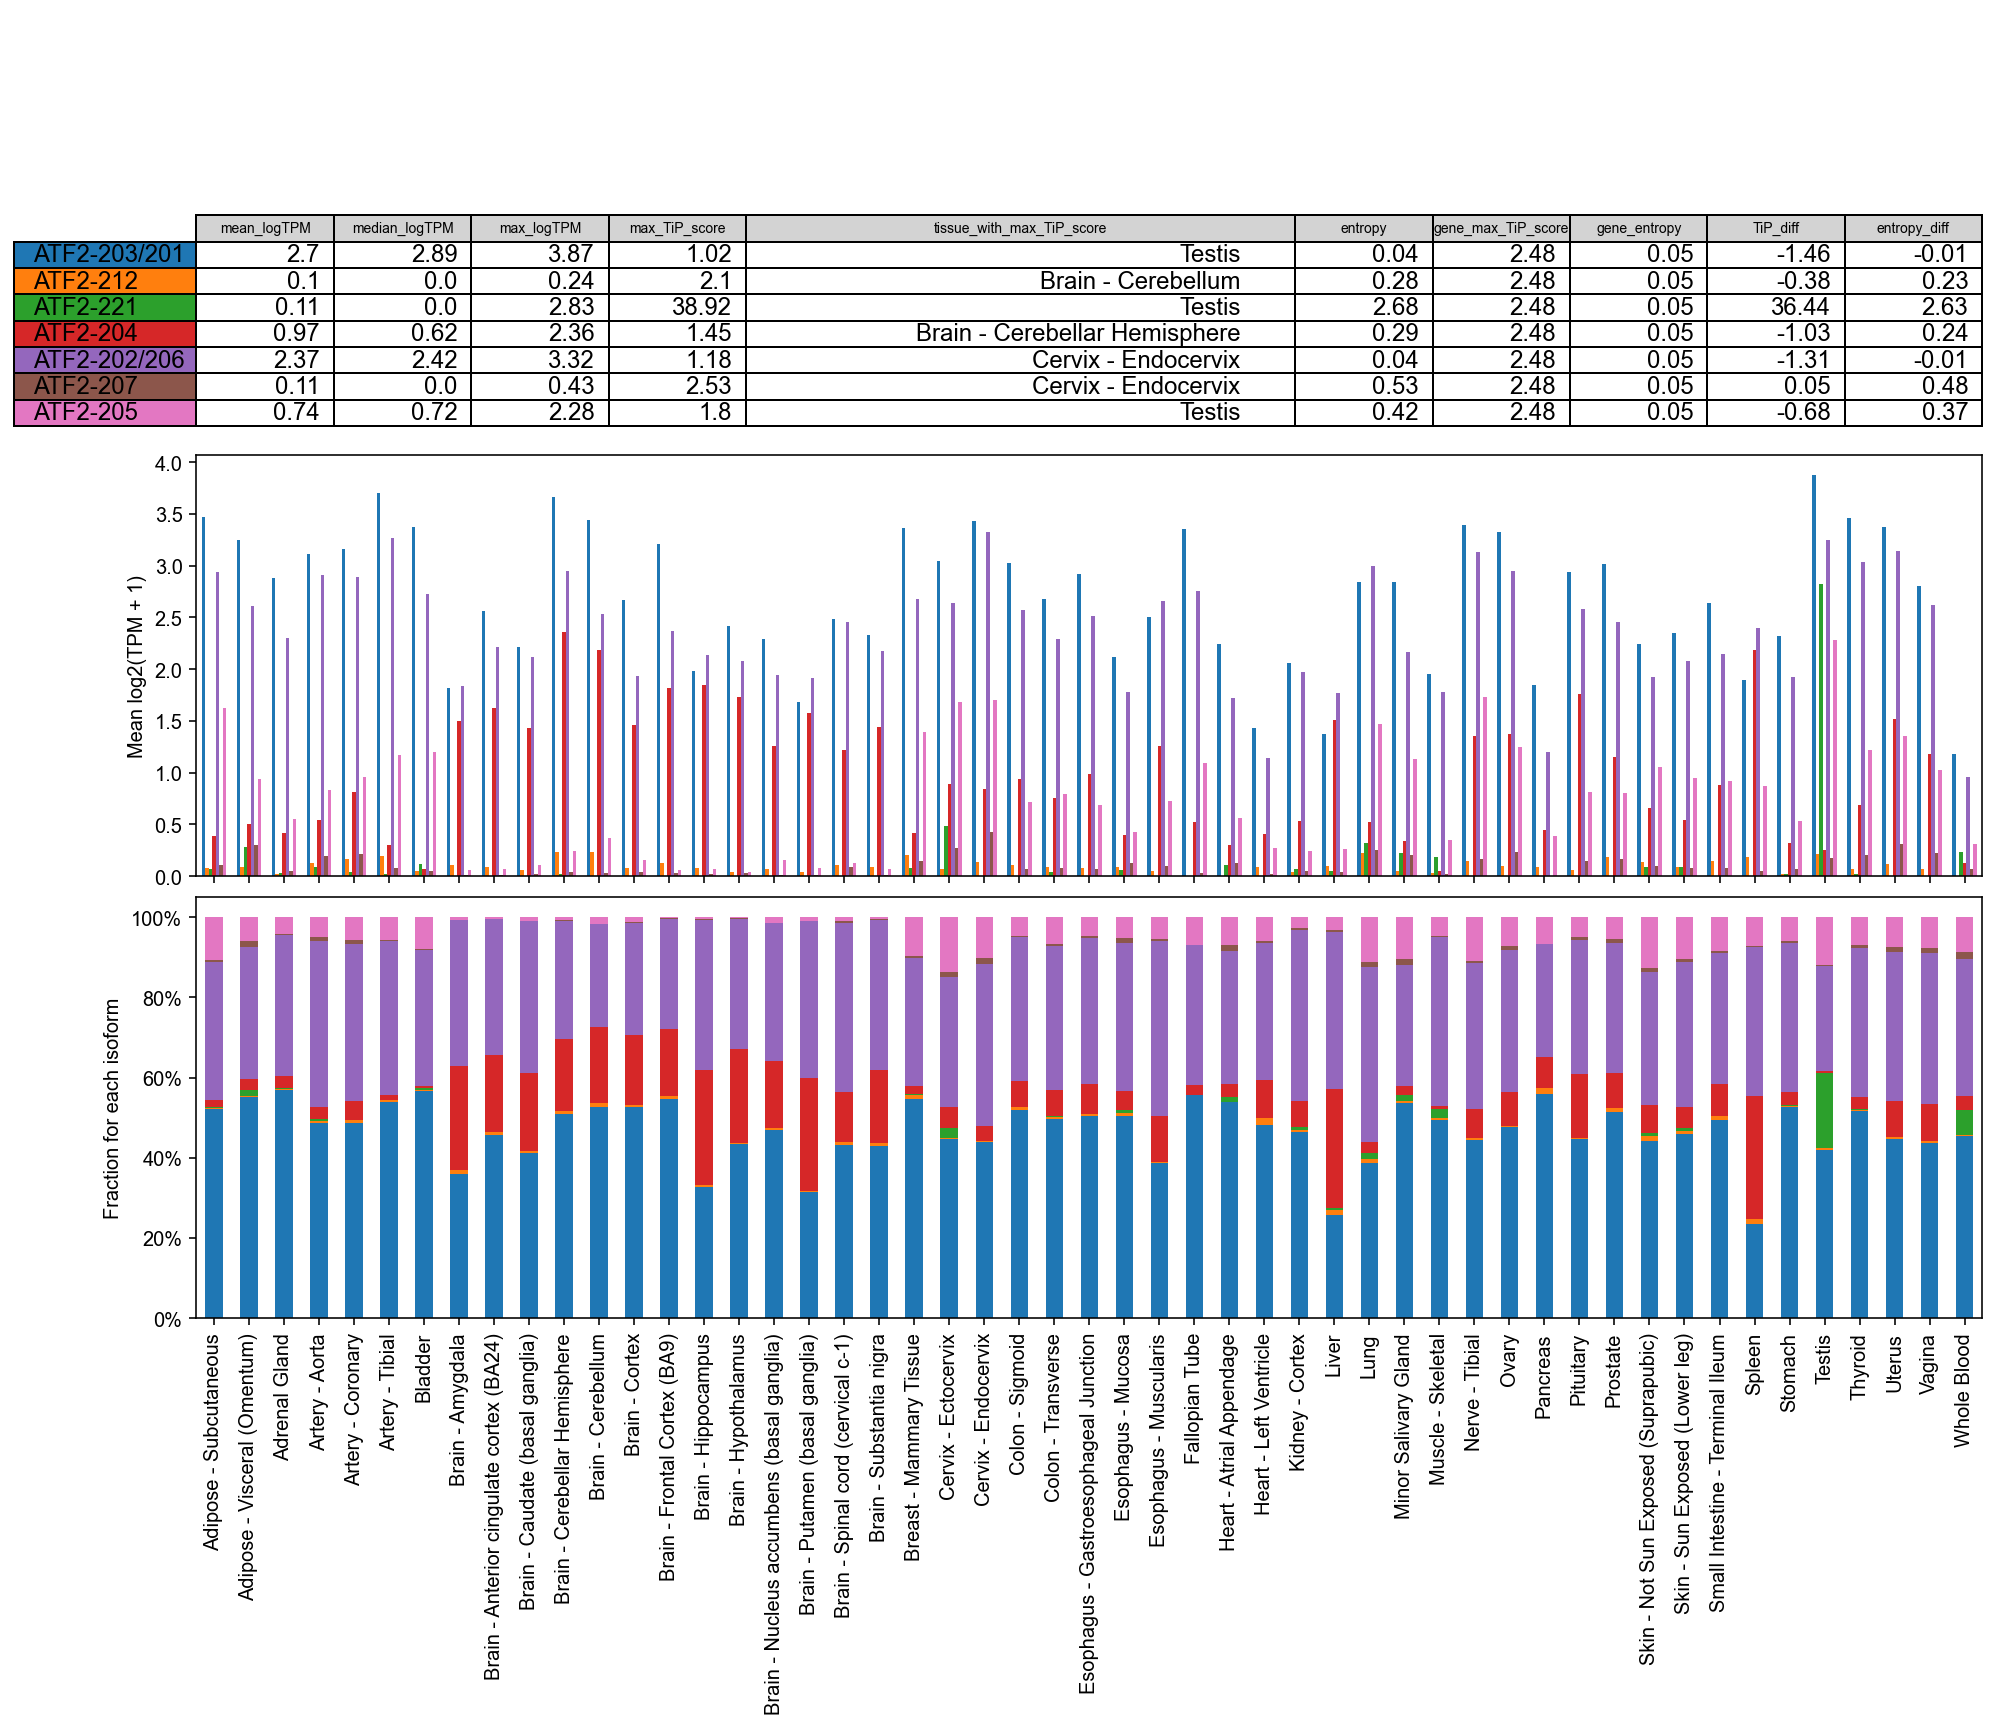

In [22]:
def table_and_graphs(gene_name):
    fig, axes = plt.subplots(3, 1, sharex=True)
    fig.set_size_inches(16, 12)
    ### table ###
    ncol = iso.shape[1] - 1
    data = iso.loc[iso['gene'] == gene_name, 
                   filter(lambda x: x != 'gene', iso.columns)].copy()
    data.index = data.index.str.replace('GC grp: ', '').str.replace('|' + gene_name+ '-', '/', regex=False)
    tab = pd.plotting.table(ax=axes[0],
                            data=data.round(2),
                            loc='lower center',
                            rowColours=['C' + str(i) for i in range((iso['gene'] == gene_name).sum())],
                            colColours=['lightgrey'] * ncol,
                            fontsize=32,
                            colWidths=[4 / (ncol + 3) if i == 4 else 1 / (ncol + 3) for i in range(ncol)])
    tab.auto_set_font_size(False)
    tab.set_fontsize(12)
    axes[0].axis('off')
    for key, cell in tab.get_celld().items():
        if key[0] == 0:
            cell.set_fontsize(7)
    ### bar chart ###
    (means.loc[genes == gene_name, :]
          .T
          .plot.bar(ax=axes[1],
                    legend=False,
                    width=0.7))
    ### percentages ###
    raw_means = 2 ** means.loc[genes == gene_name] - 1.
    (raw_means.div(raw_means.sum(axis=0))
              .T.plot.bar(ax=axes[2], 
                          stacked=True,
                          legend=False))
    axes[1].set_ylabel('Mean log2(TPM + 1)')
    #axes[0].set_title(gene_name)
    axes[2].set_ylabel('Fraction for each isoform')
    axes[2].set_yticklabels(['{:.0%}'.format(t) for t in axes[2].get_yticks()])
    plt.subplots_adjust(hspace=0.05)
    fig_dir = Path('../../figures/tissue_expression_per_gene')
    fig_dir.mkdir(exist_ok=True)
    plt.savefig(fig_dir / (gene_name + '_tissue_expression.pdf'),
                bbox_inches='tight')

table_and_graphs('ATF2')

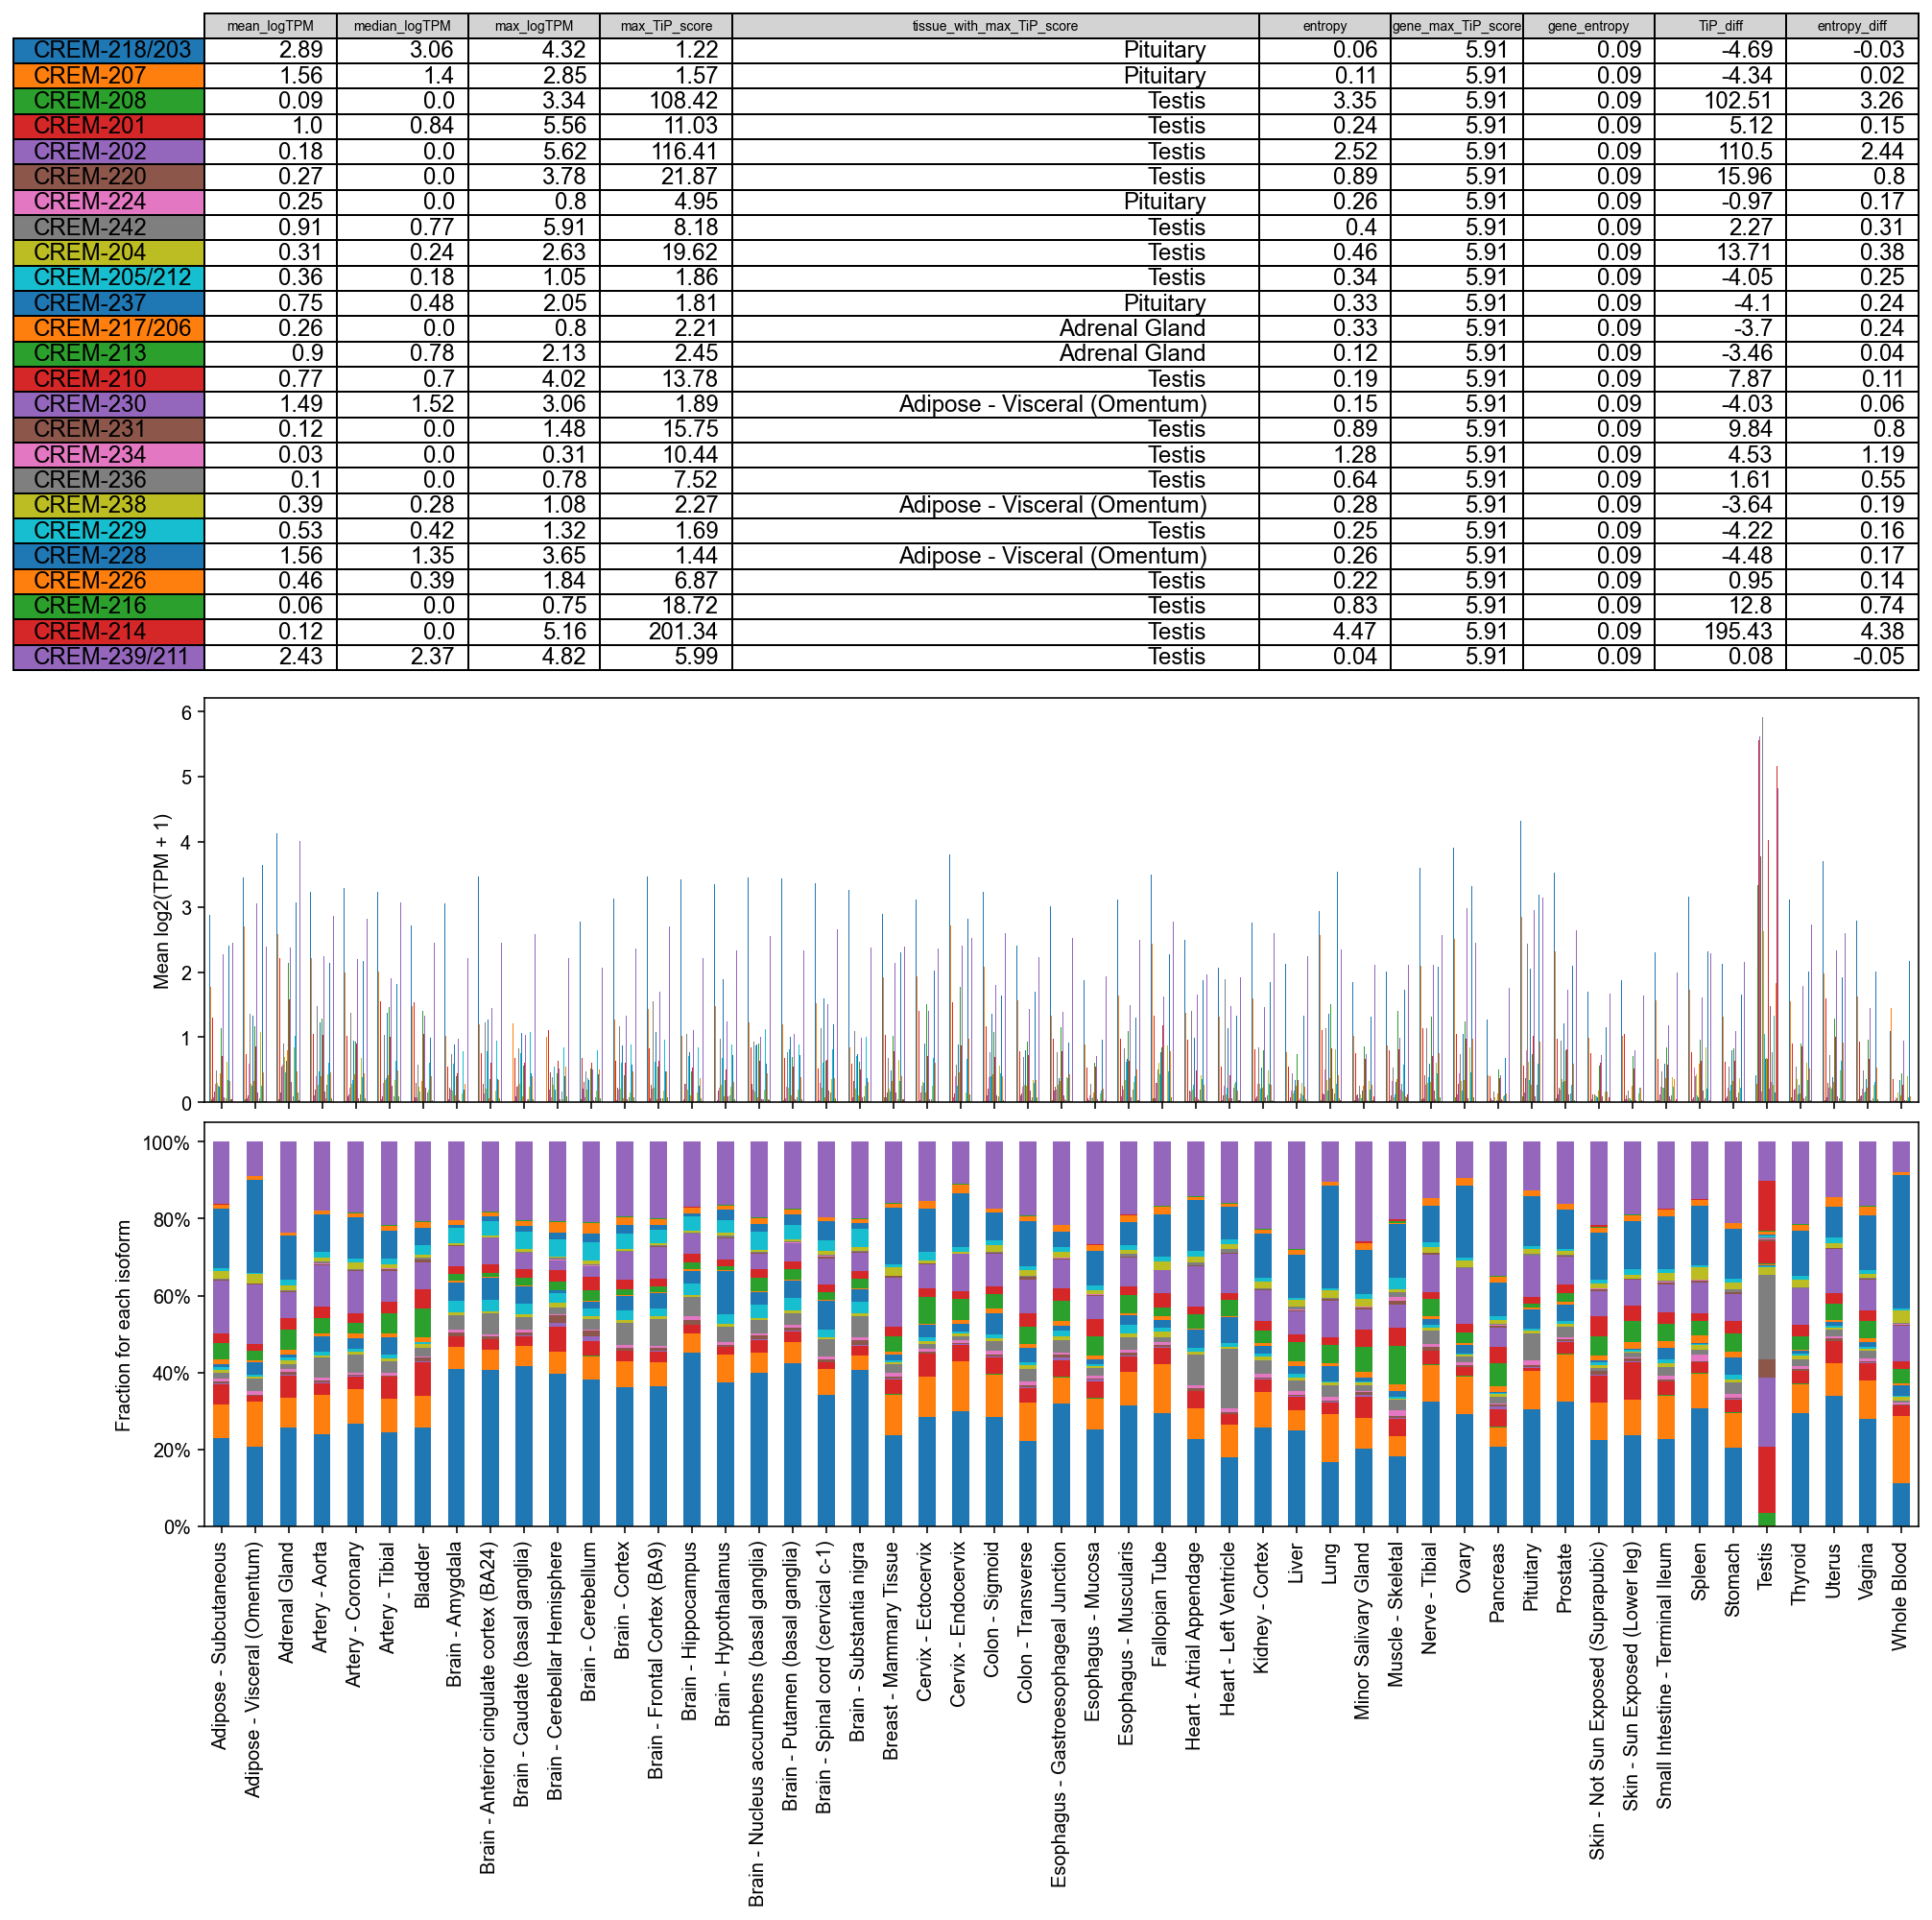

In [23]:
# largest number of isoforms
table_and_graphs('CREM')

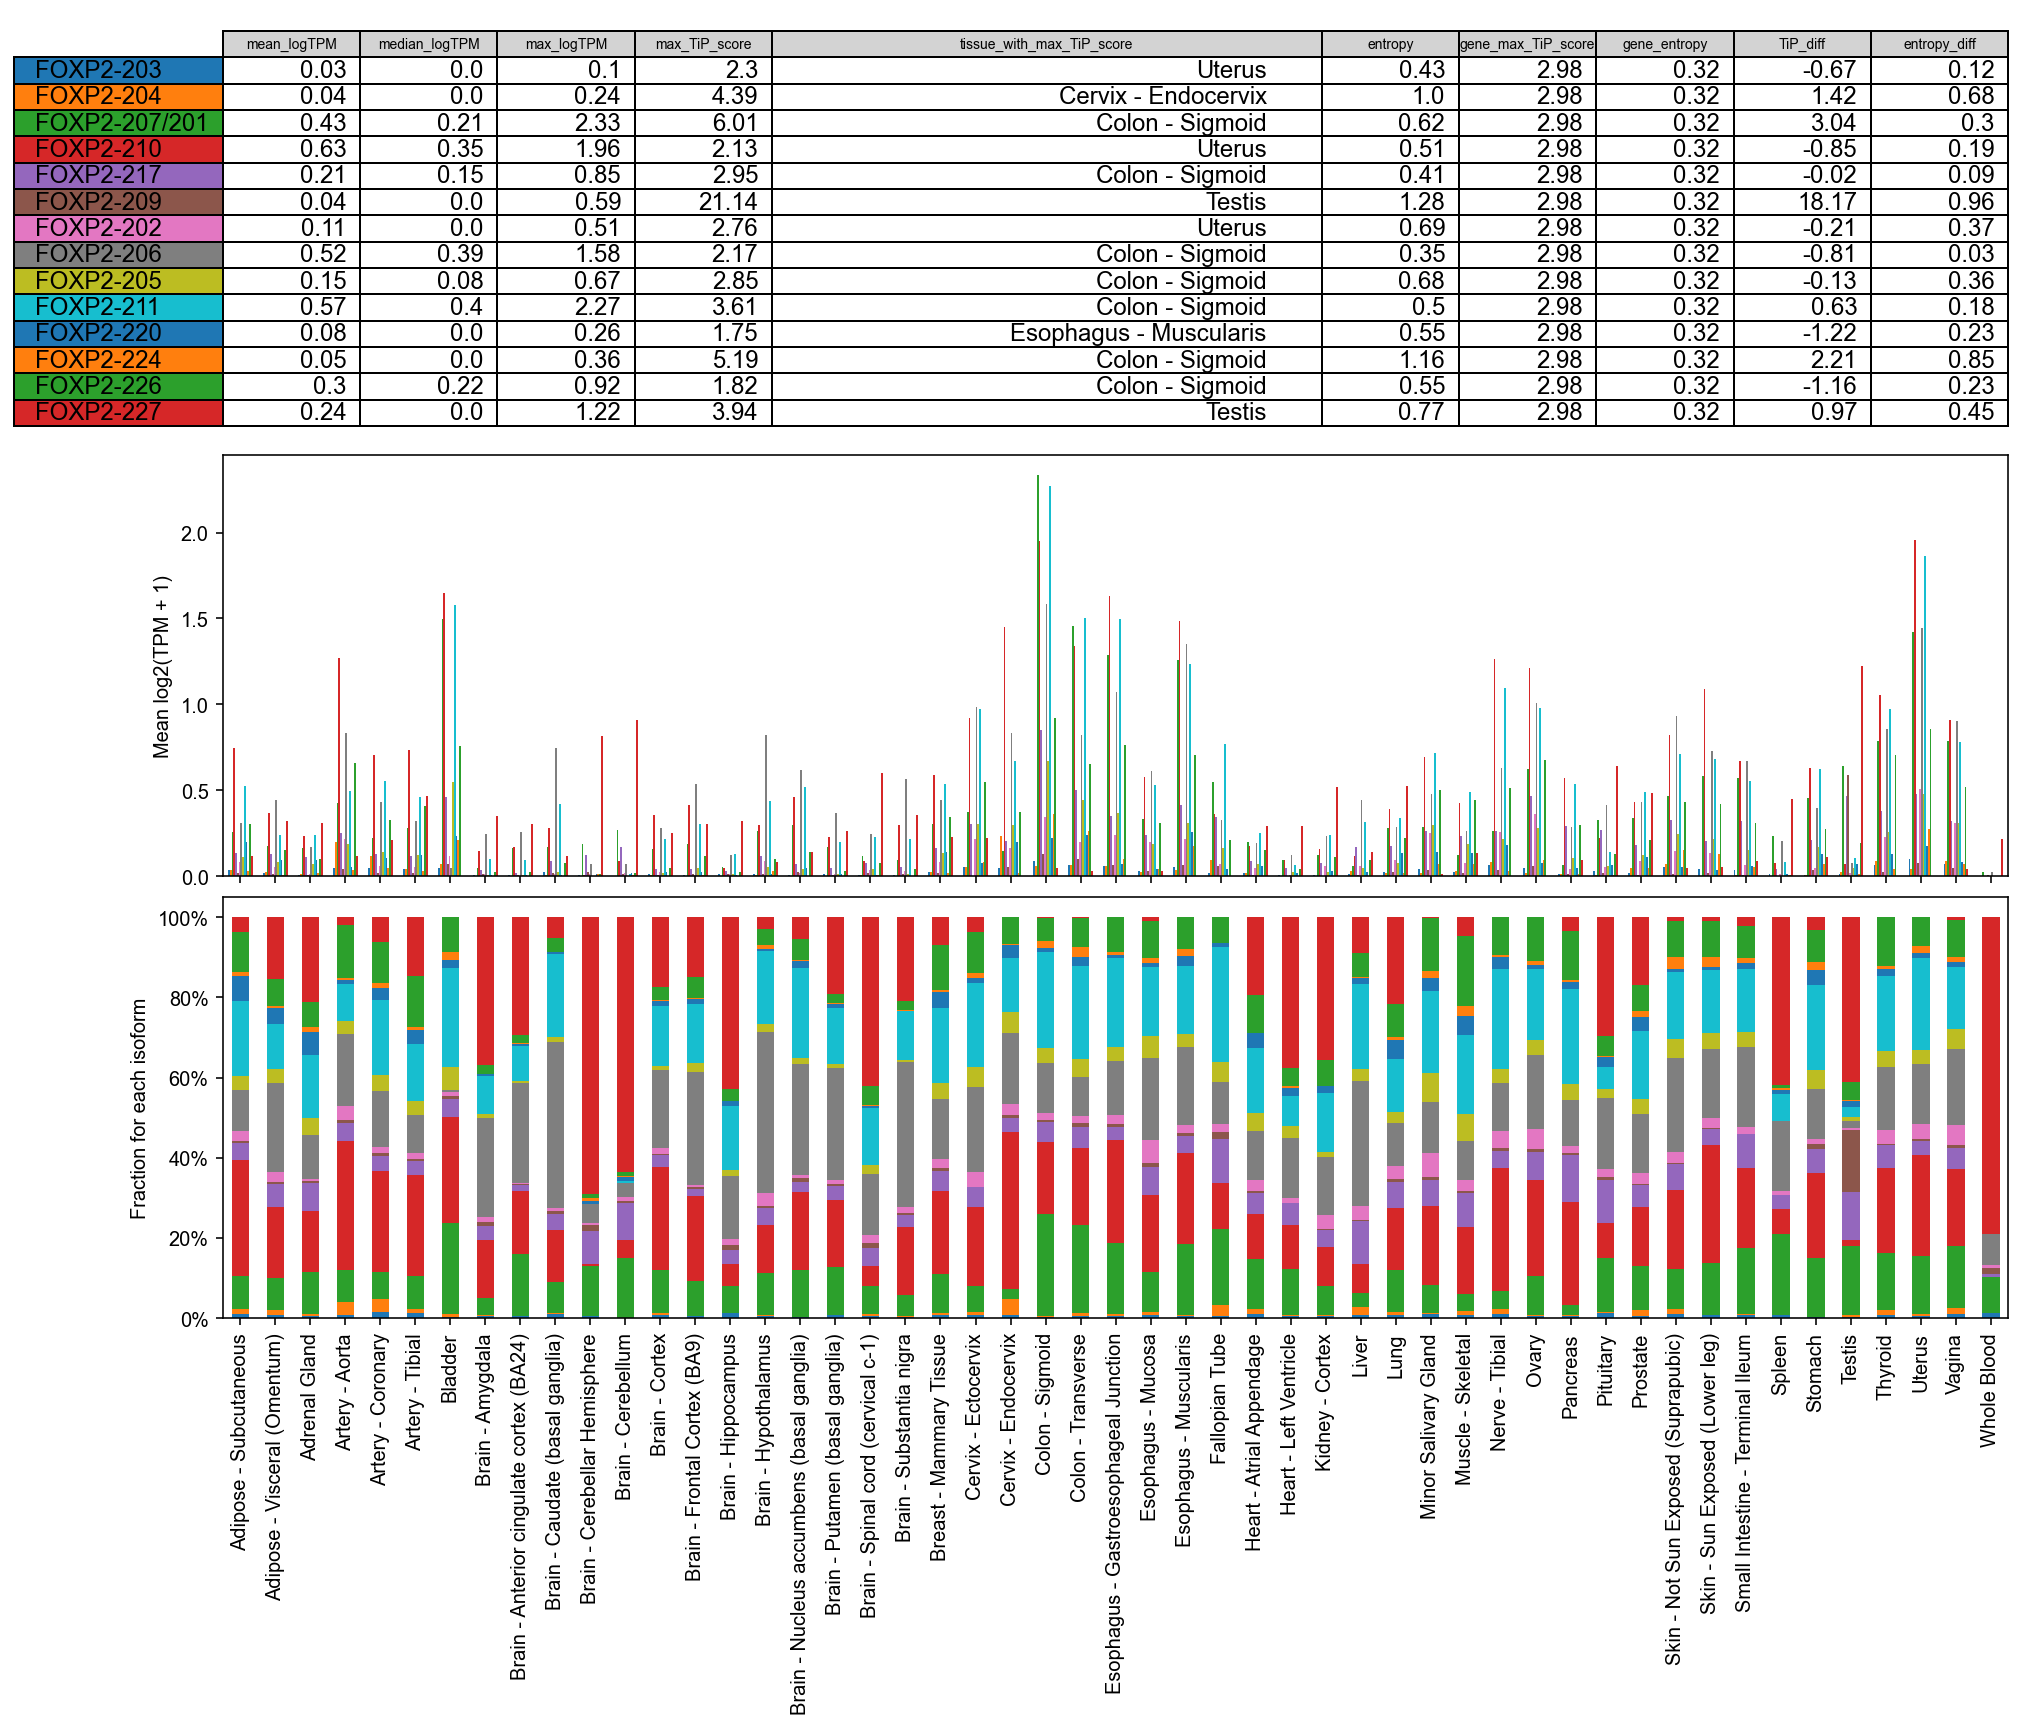

In [24]:
table_and_graphs('FOXP2')

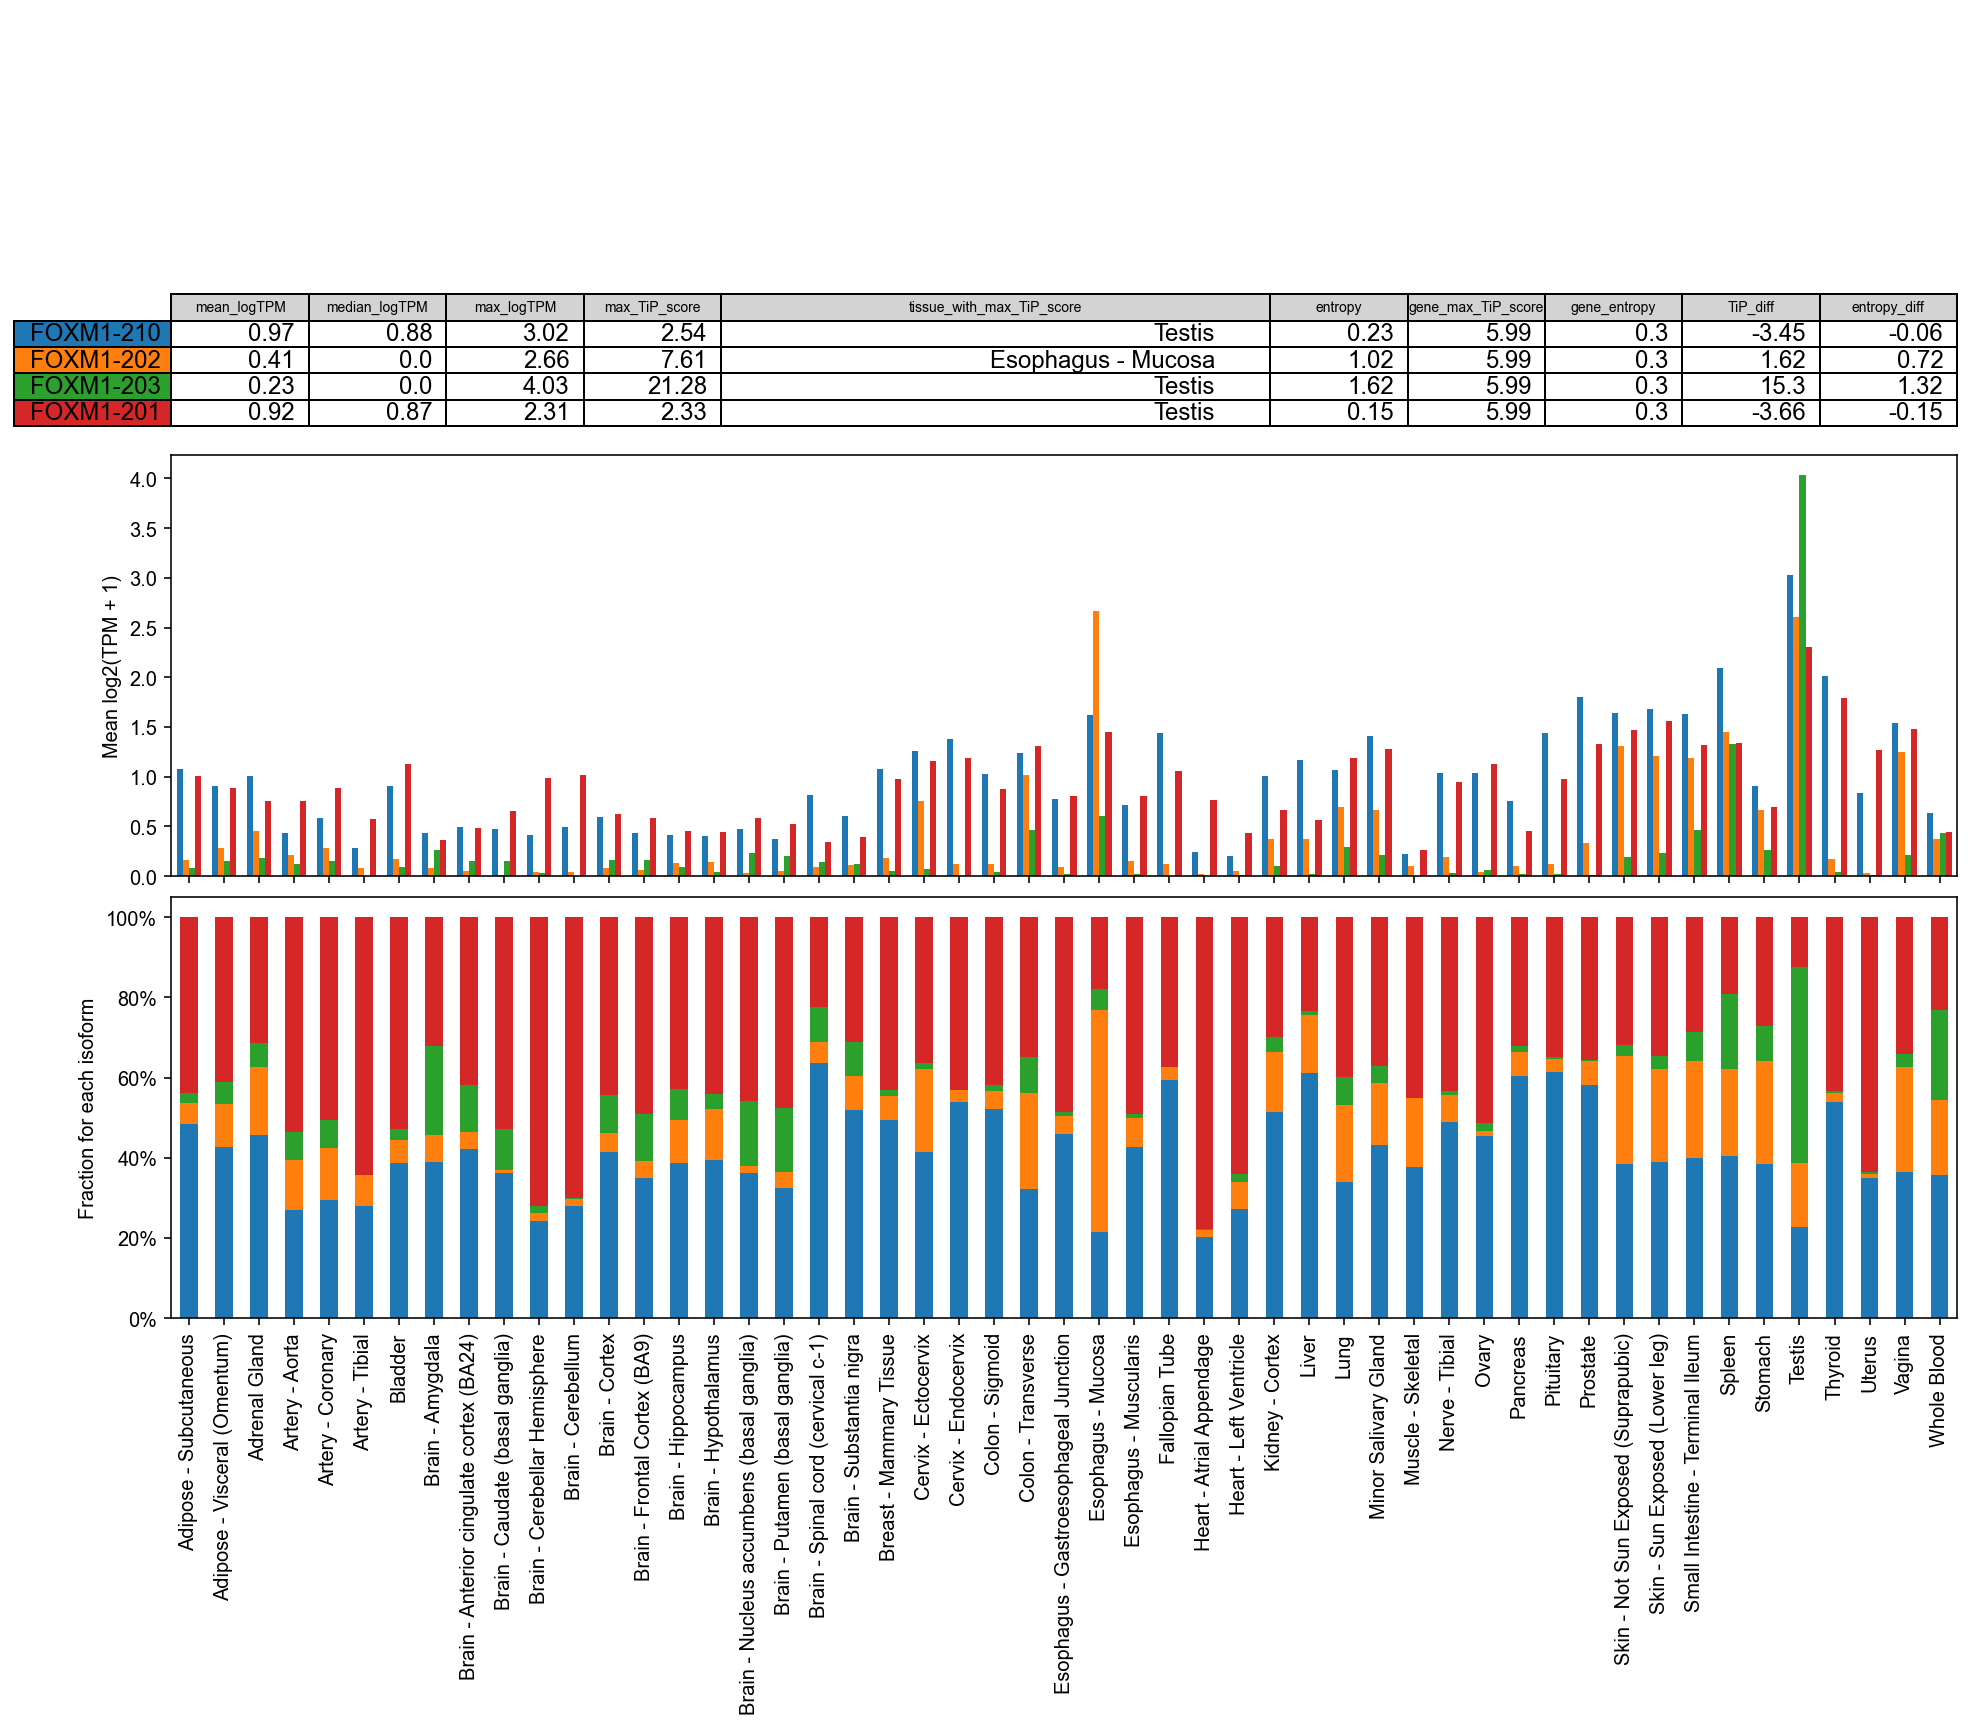

In [25]:
table_and_graphs('FOXM1')

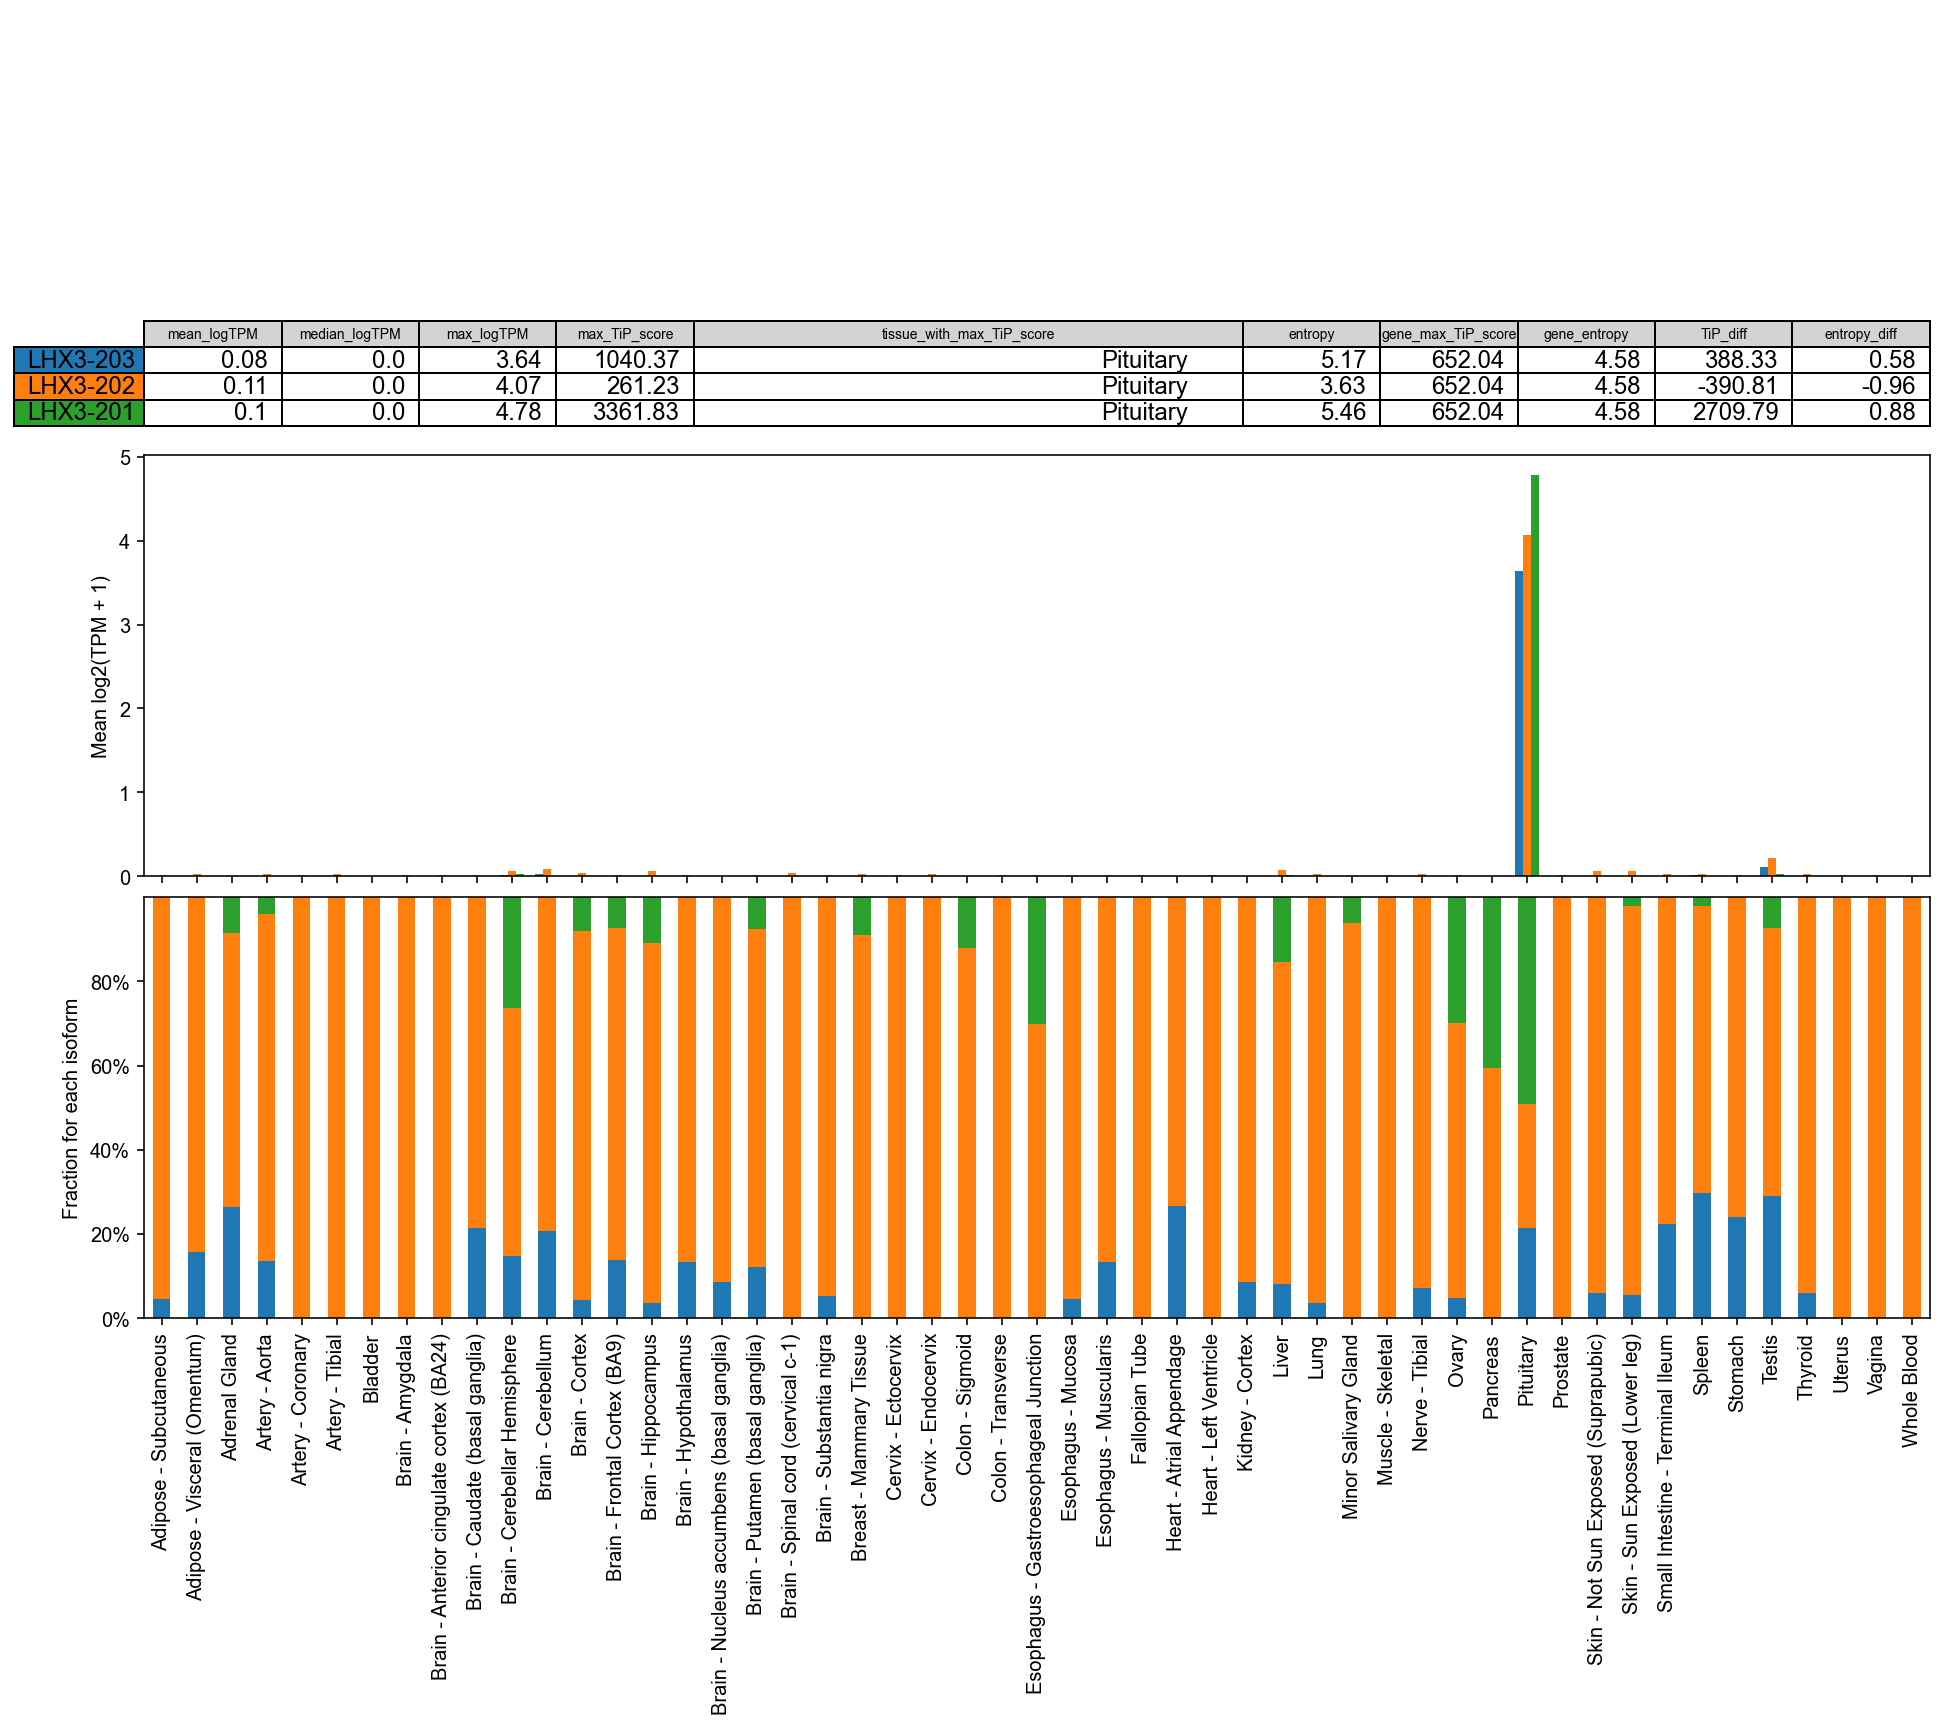

In [26]:
# interesting because all isoforms in one tissue
table_and_graphs('LHX3')

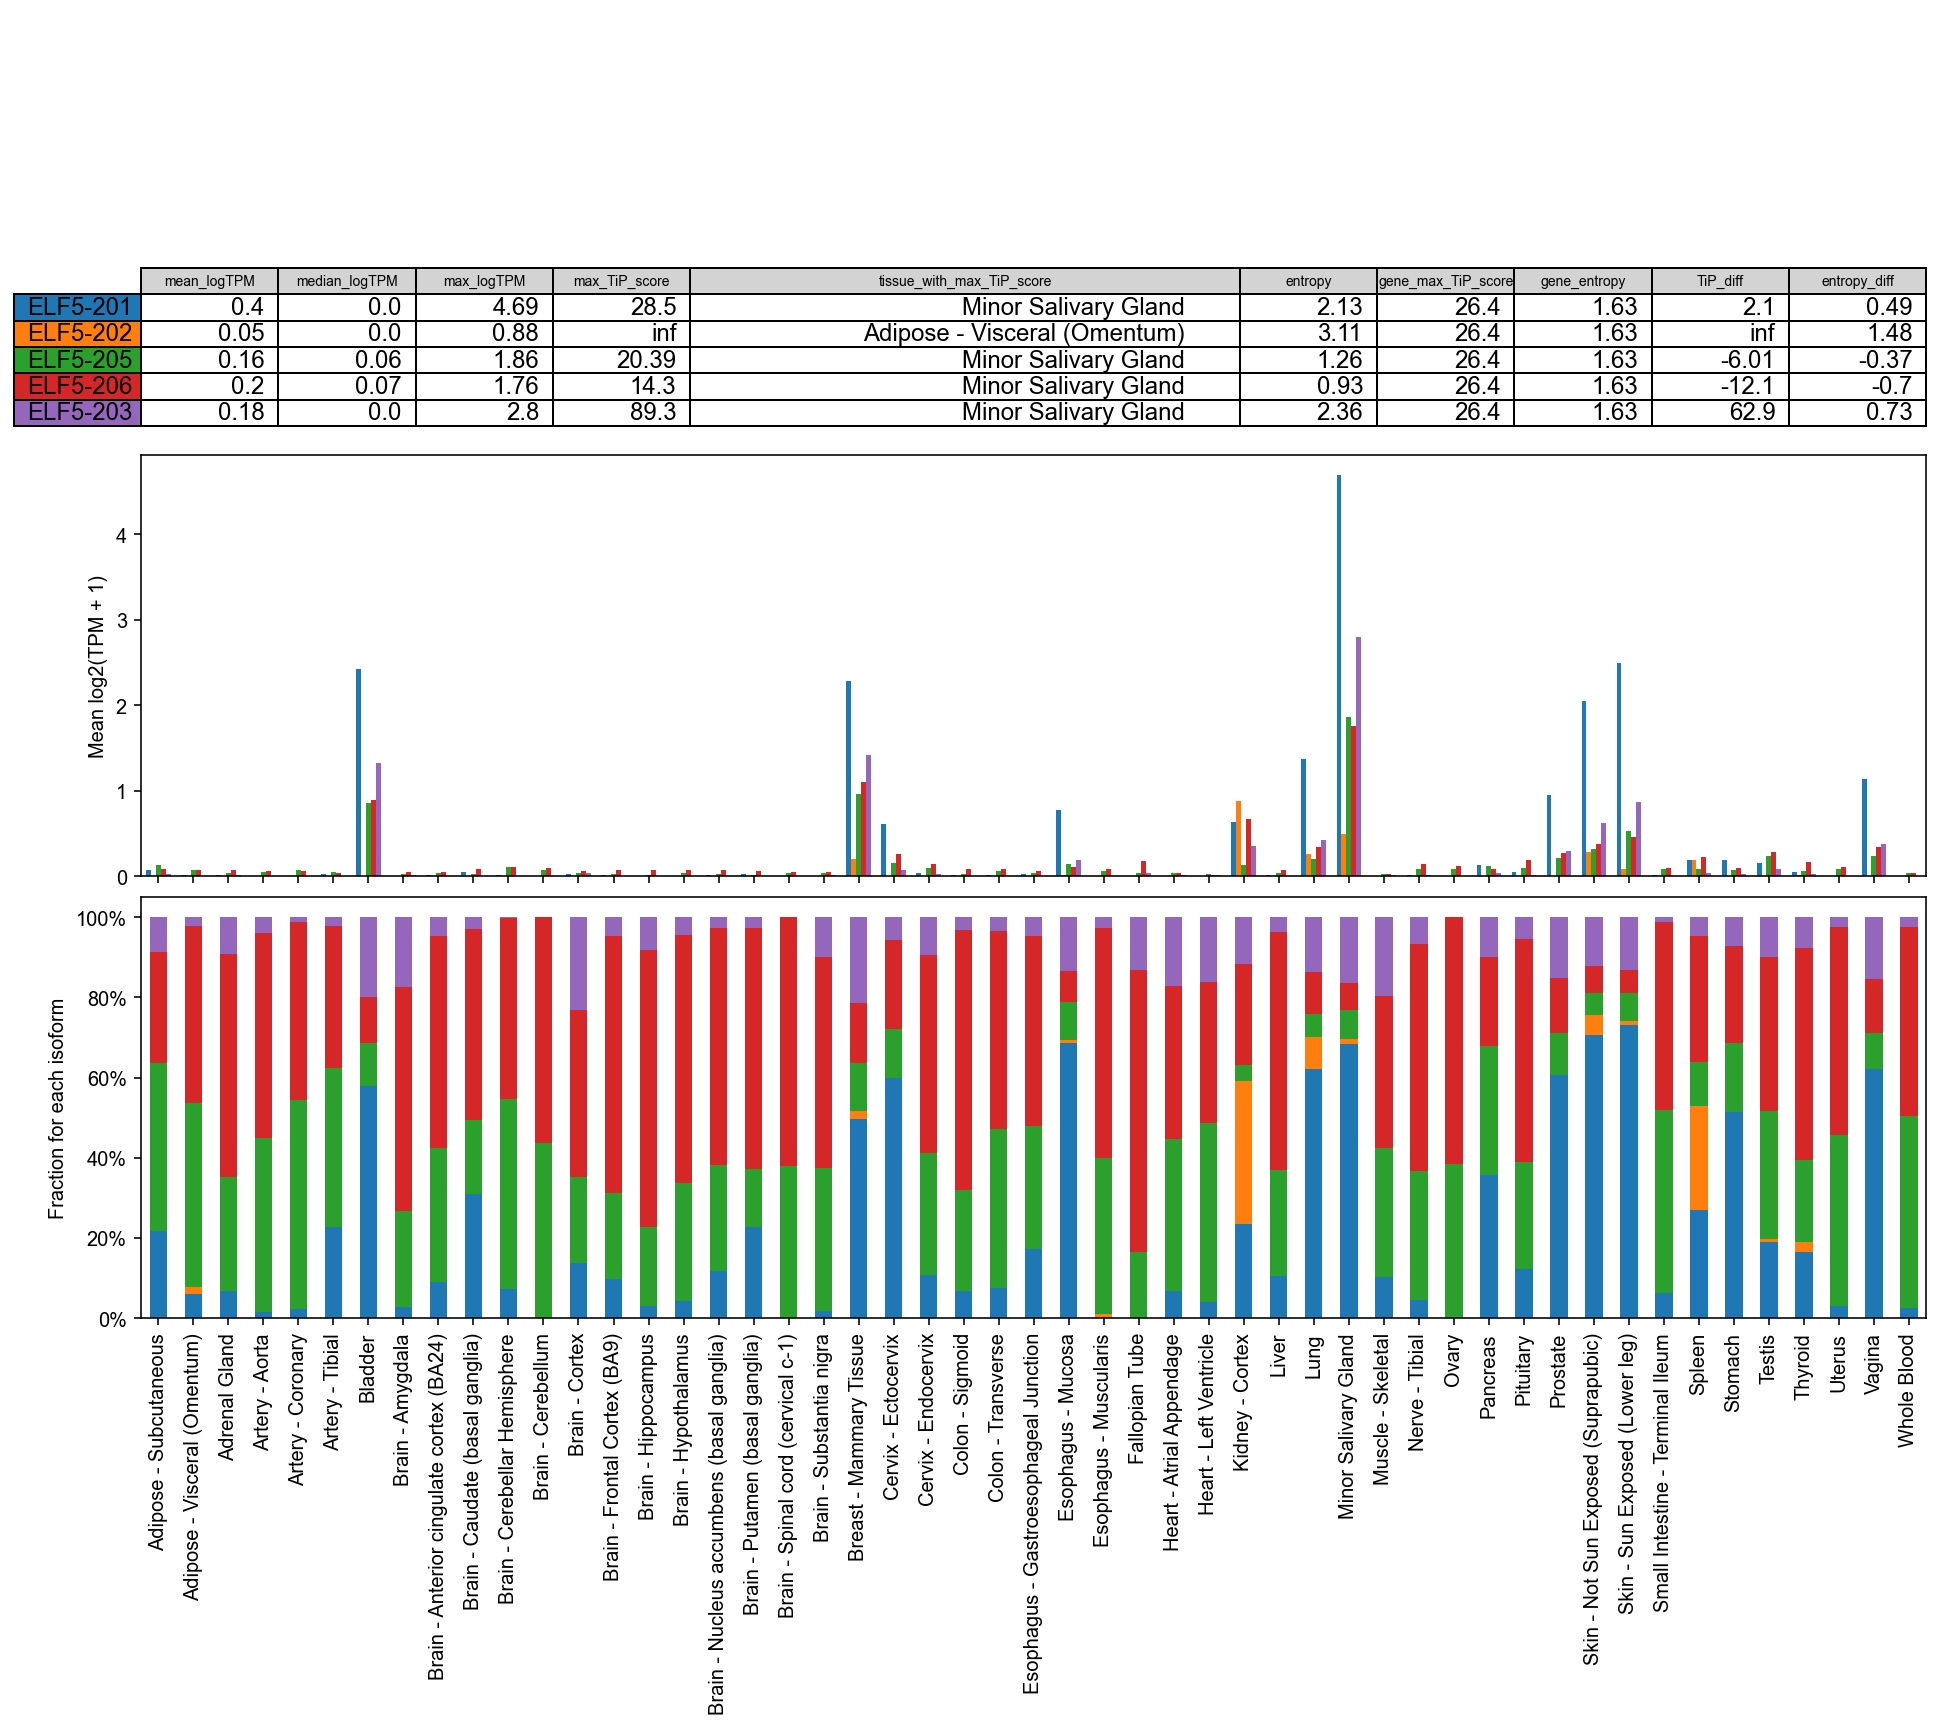

In [27]:
table_and_graphs('ELF5')  # Zero counts

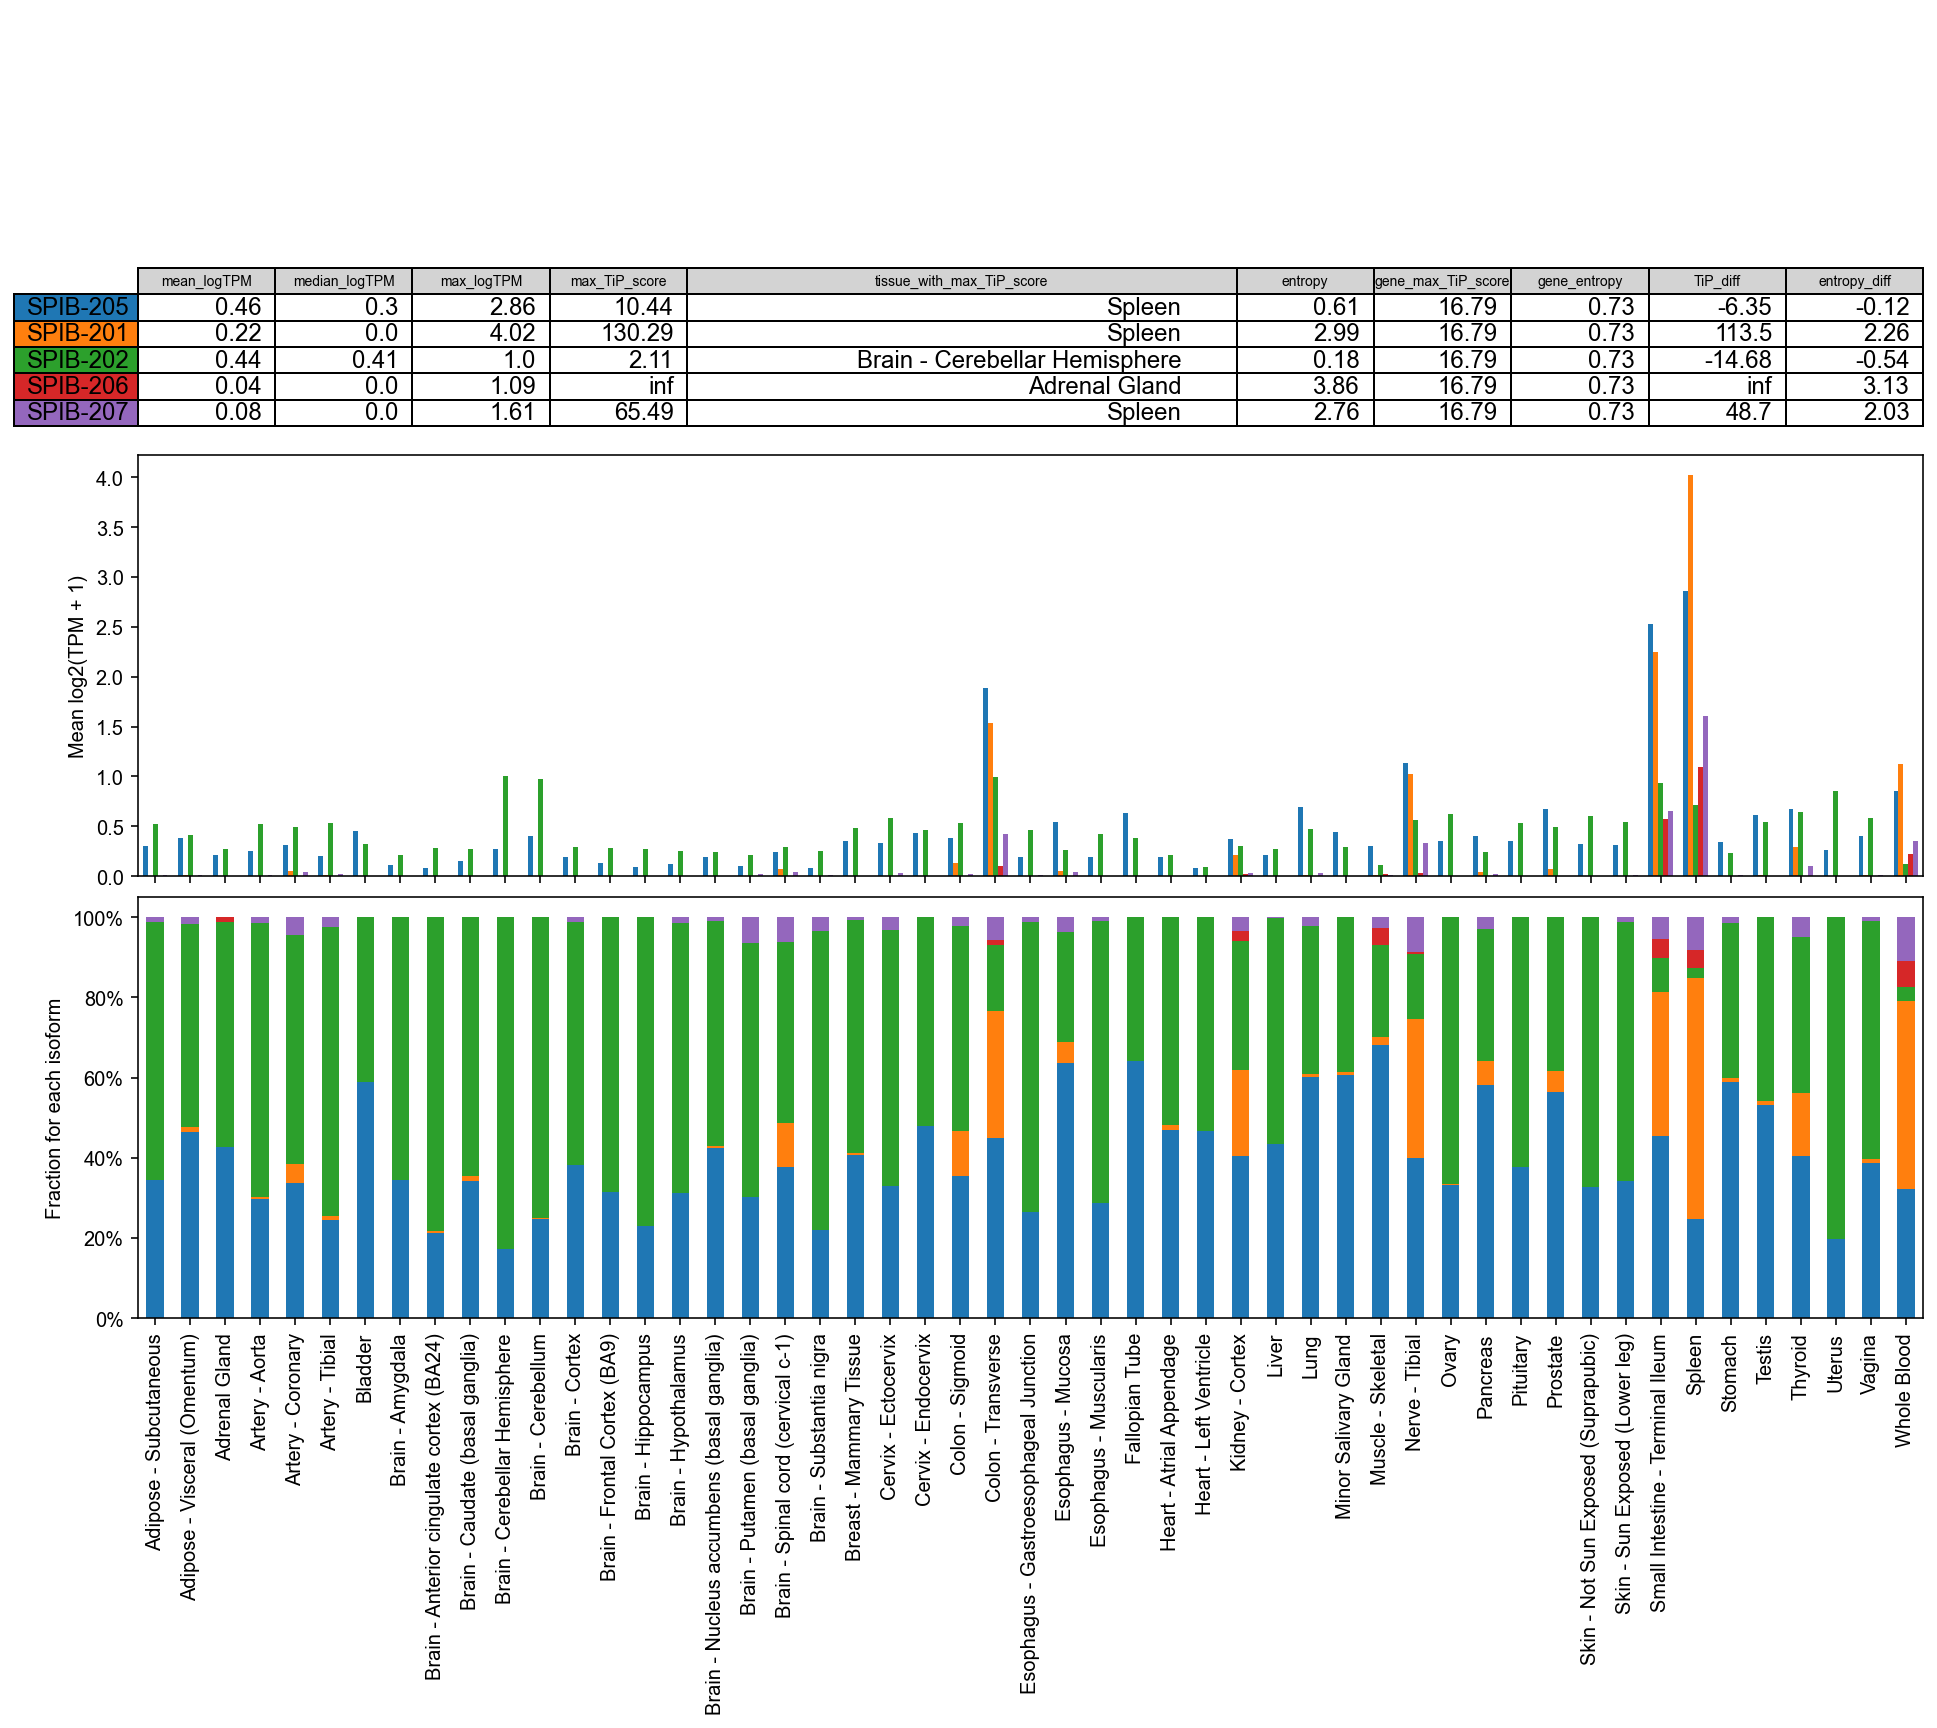

In [28]:
table_and_graphs('SPIB')  # Zero counts

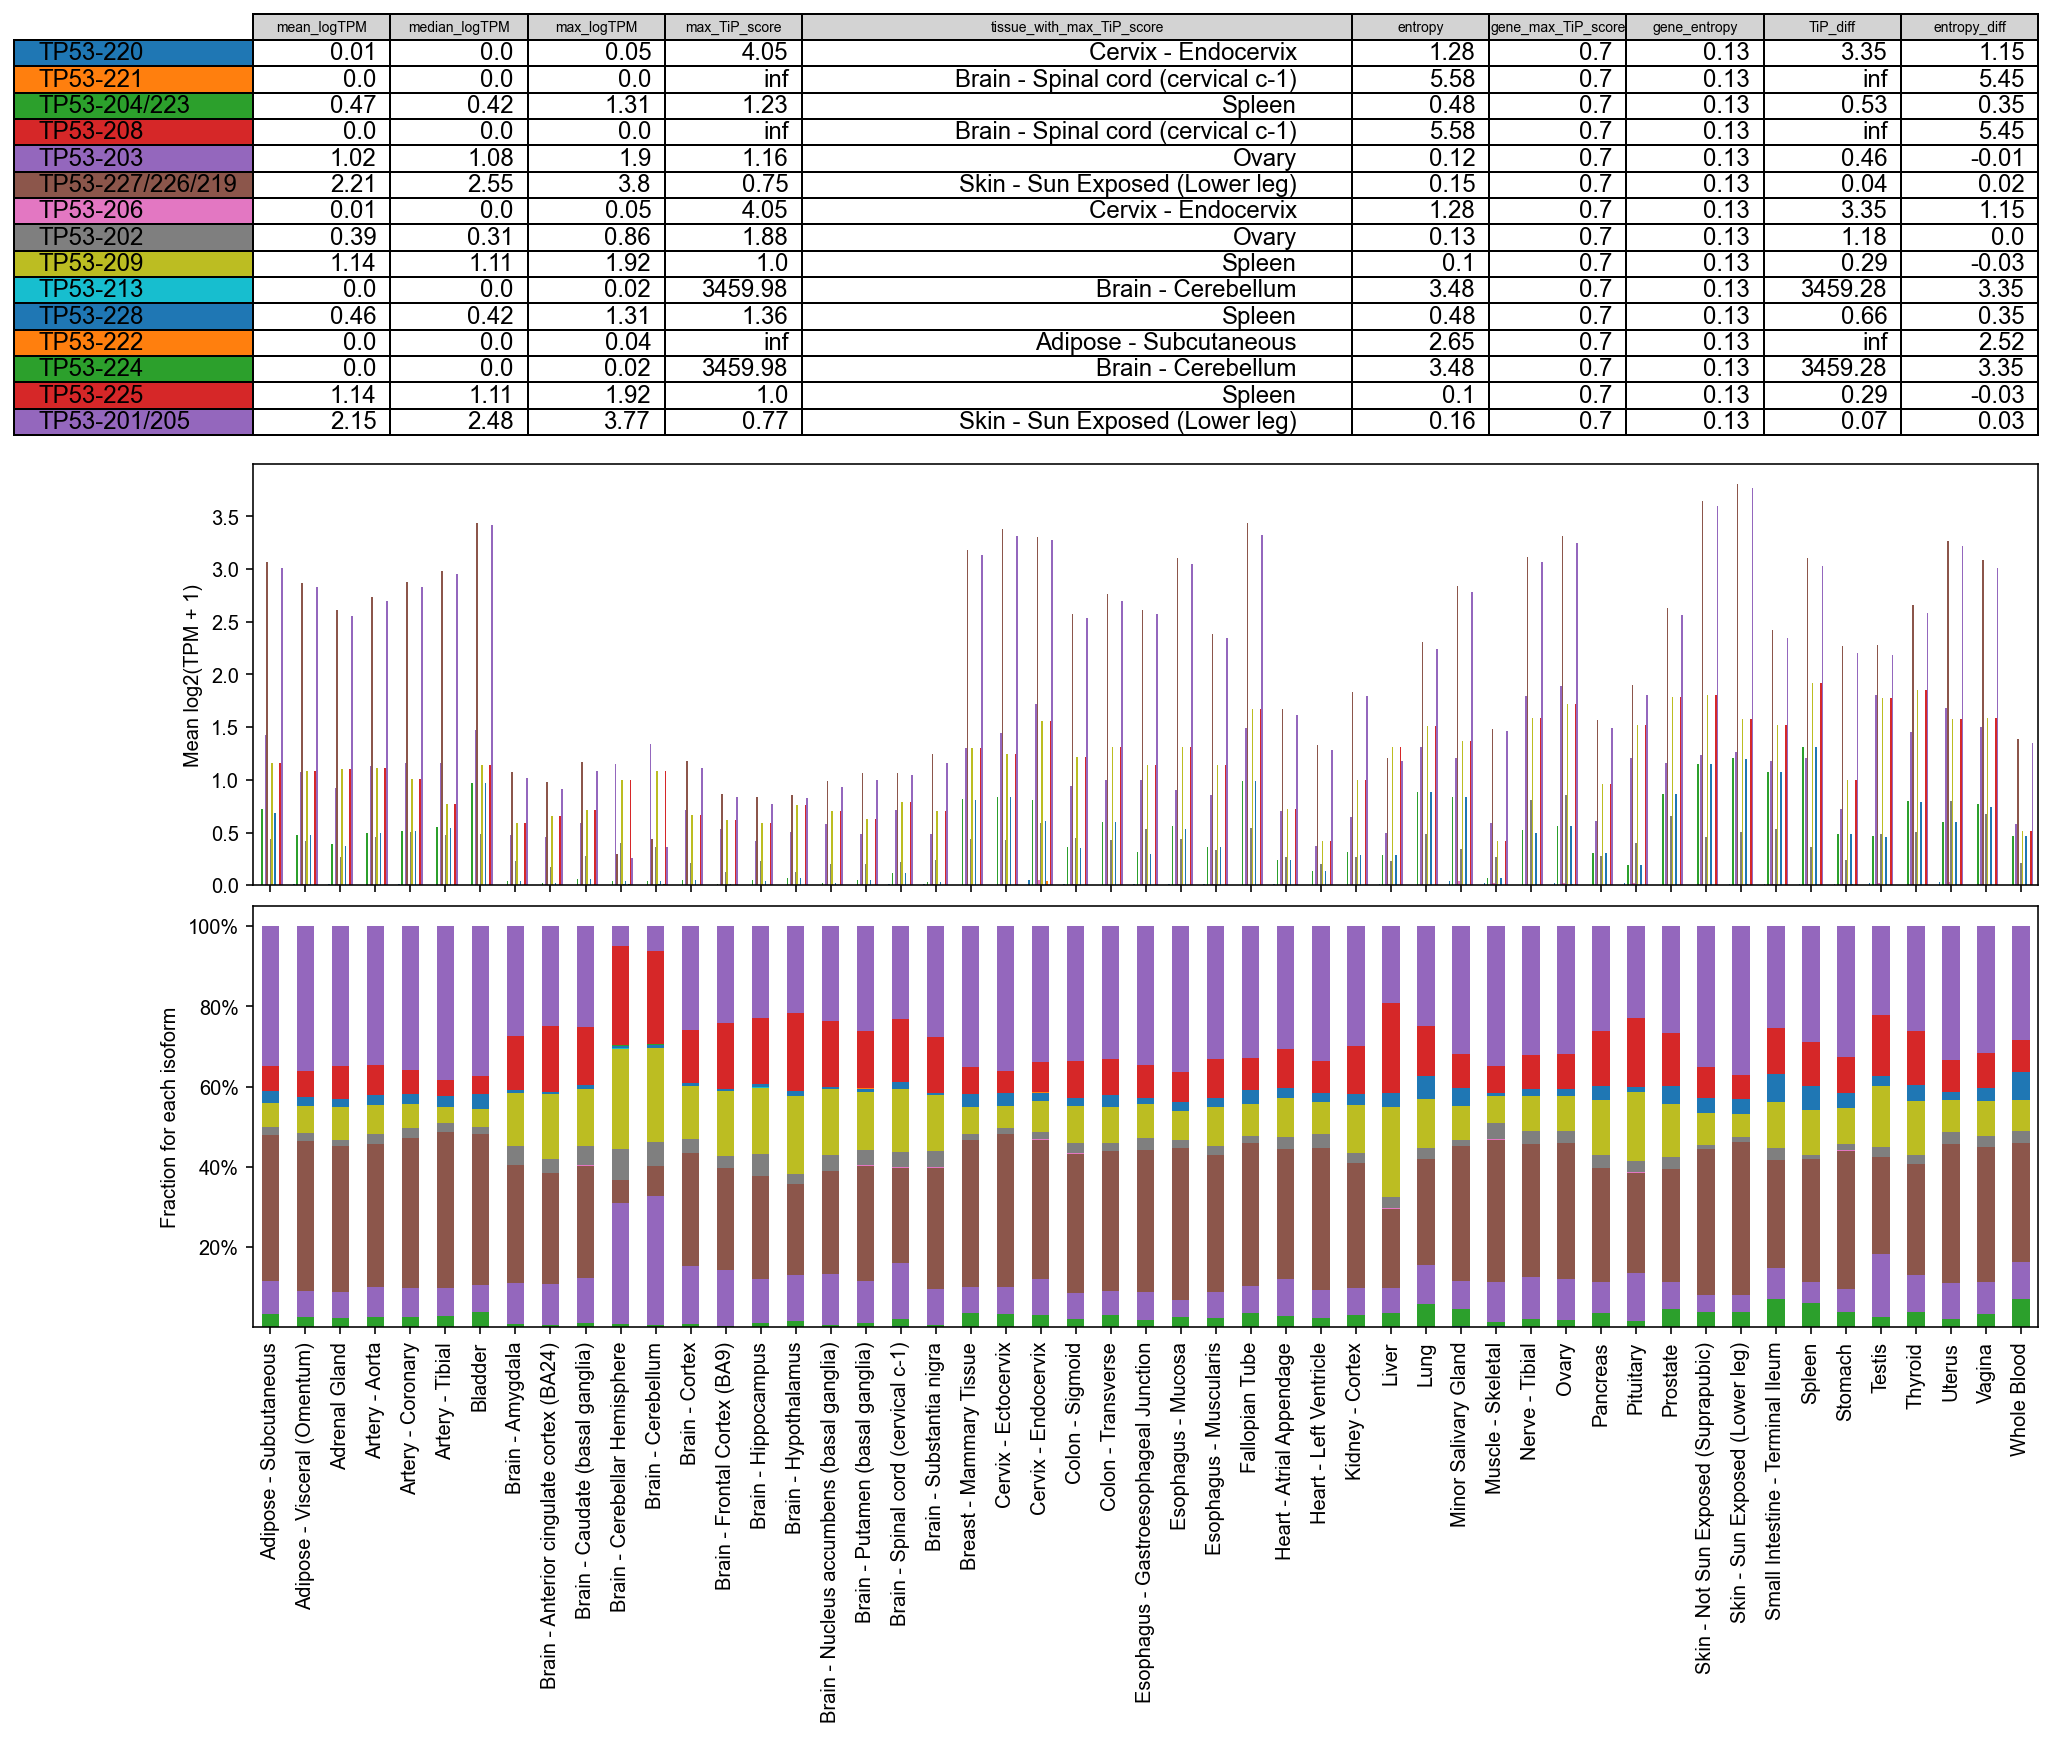

In [29]:
table_and_graphs('TP53')

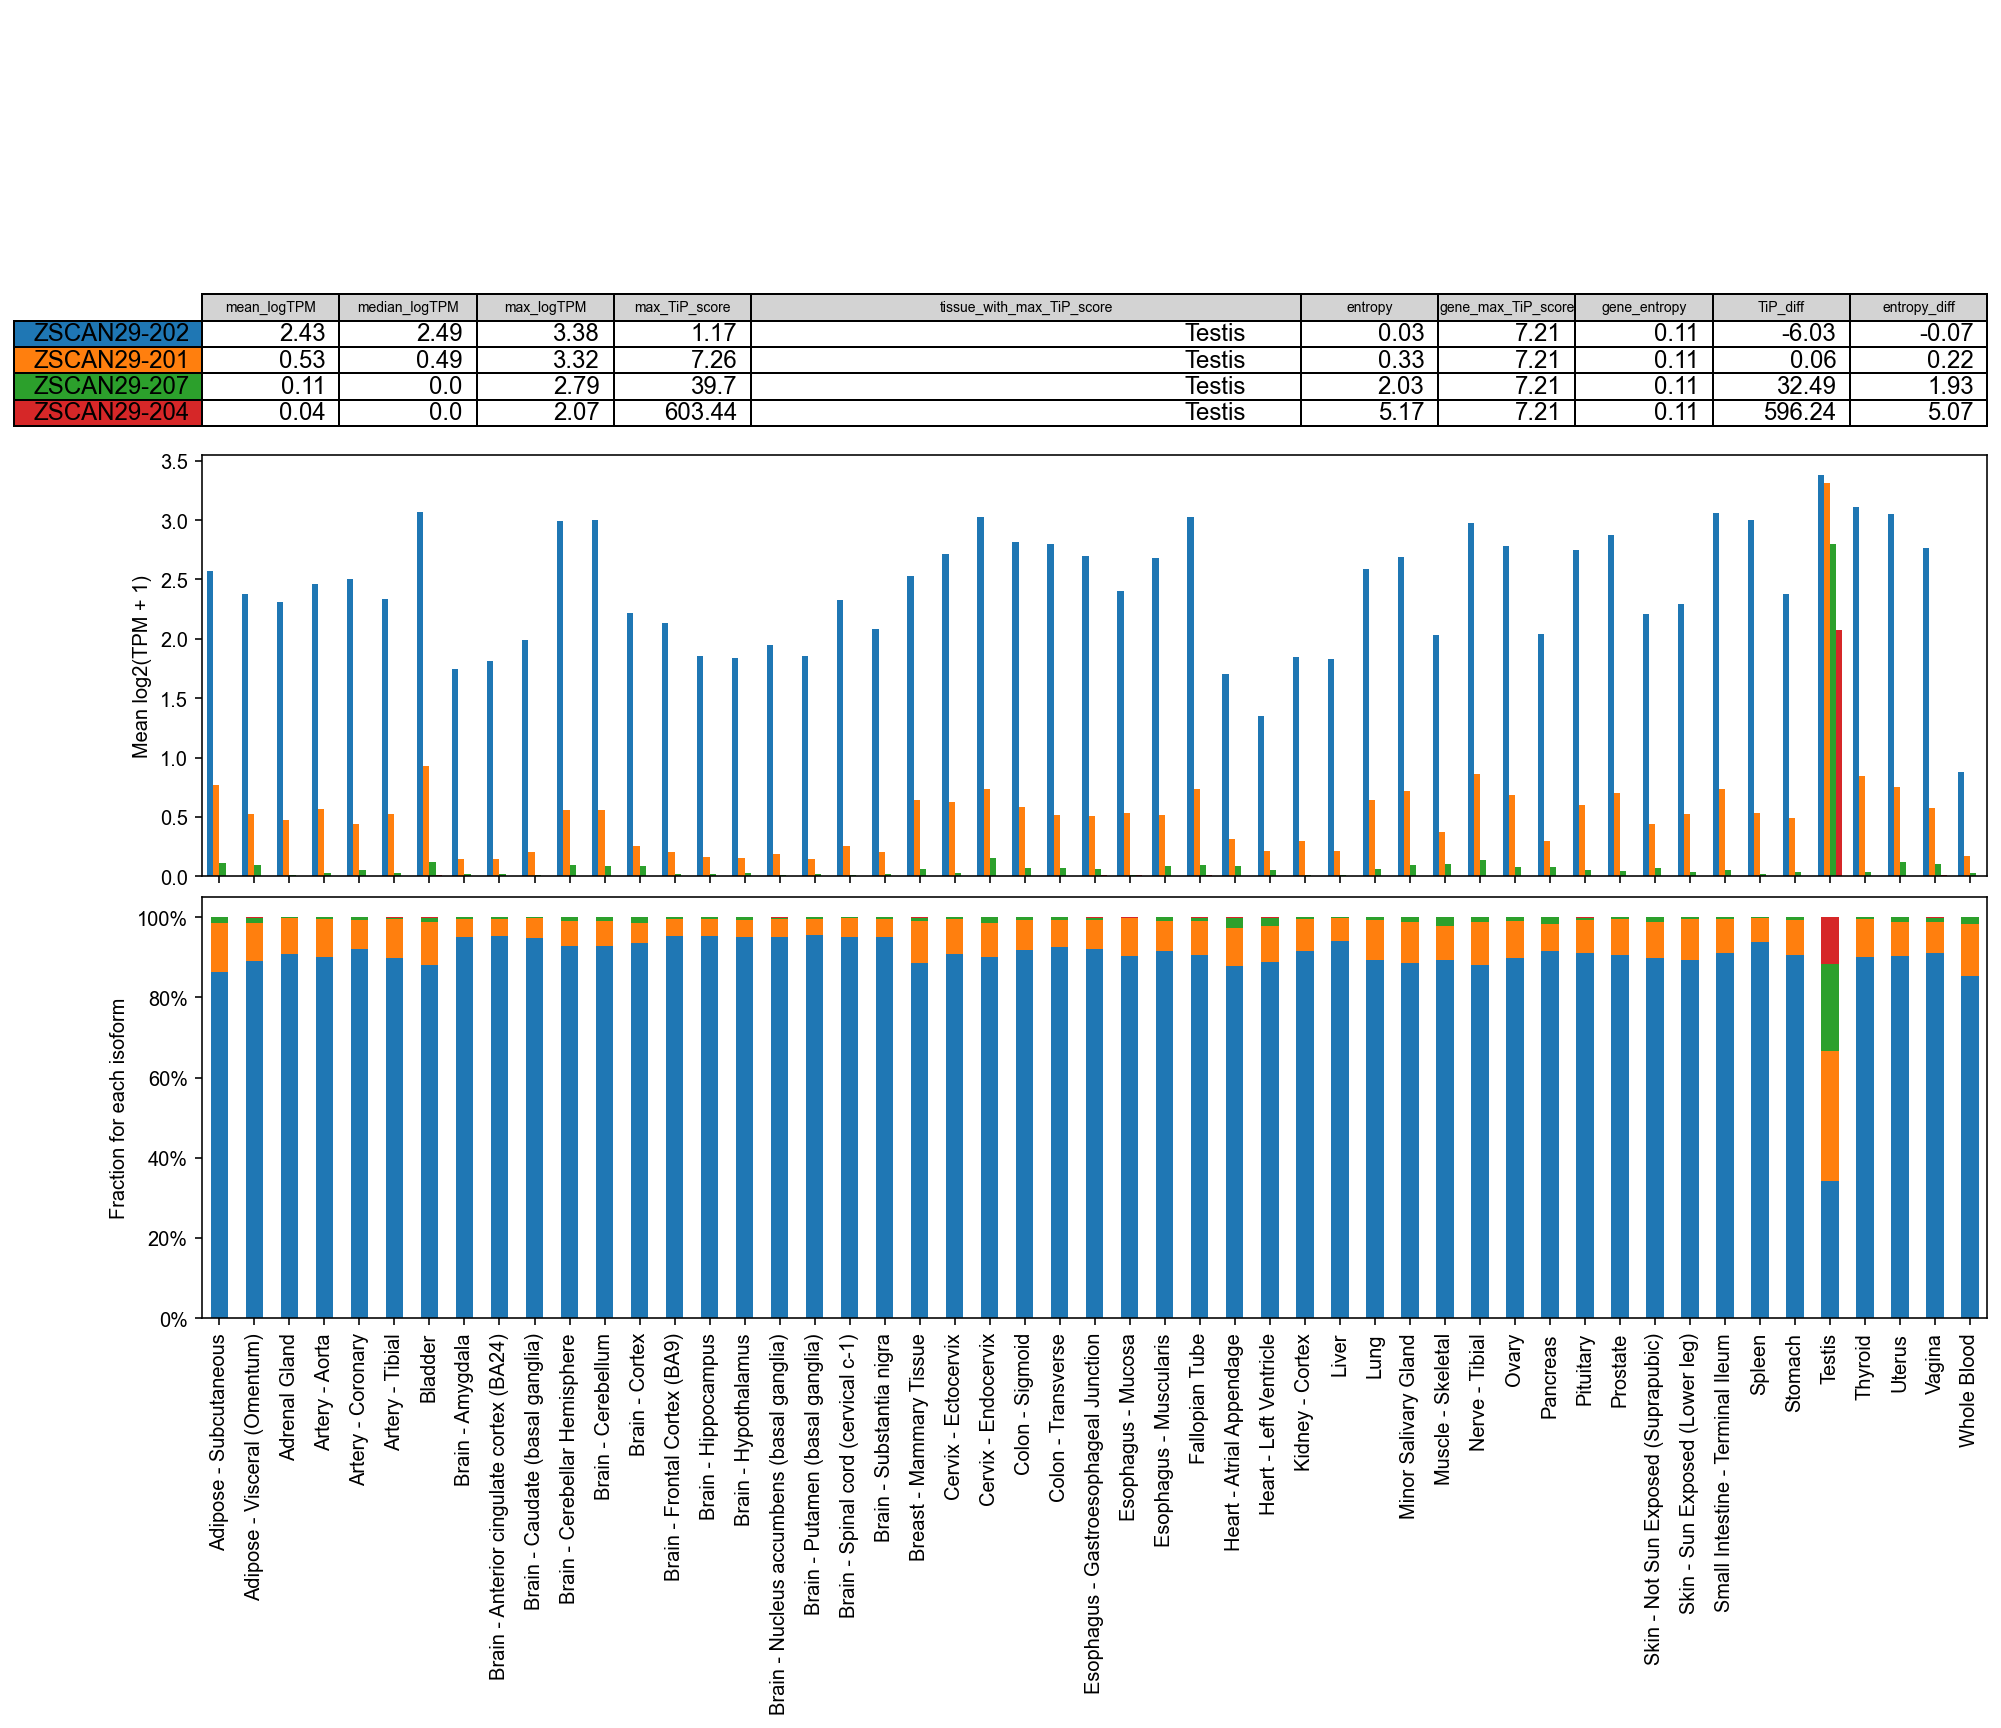

In [30]:
table_and_graphs('ZSCAN29')

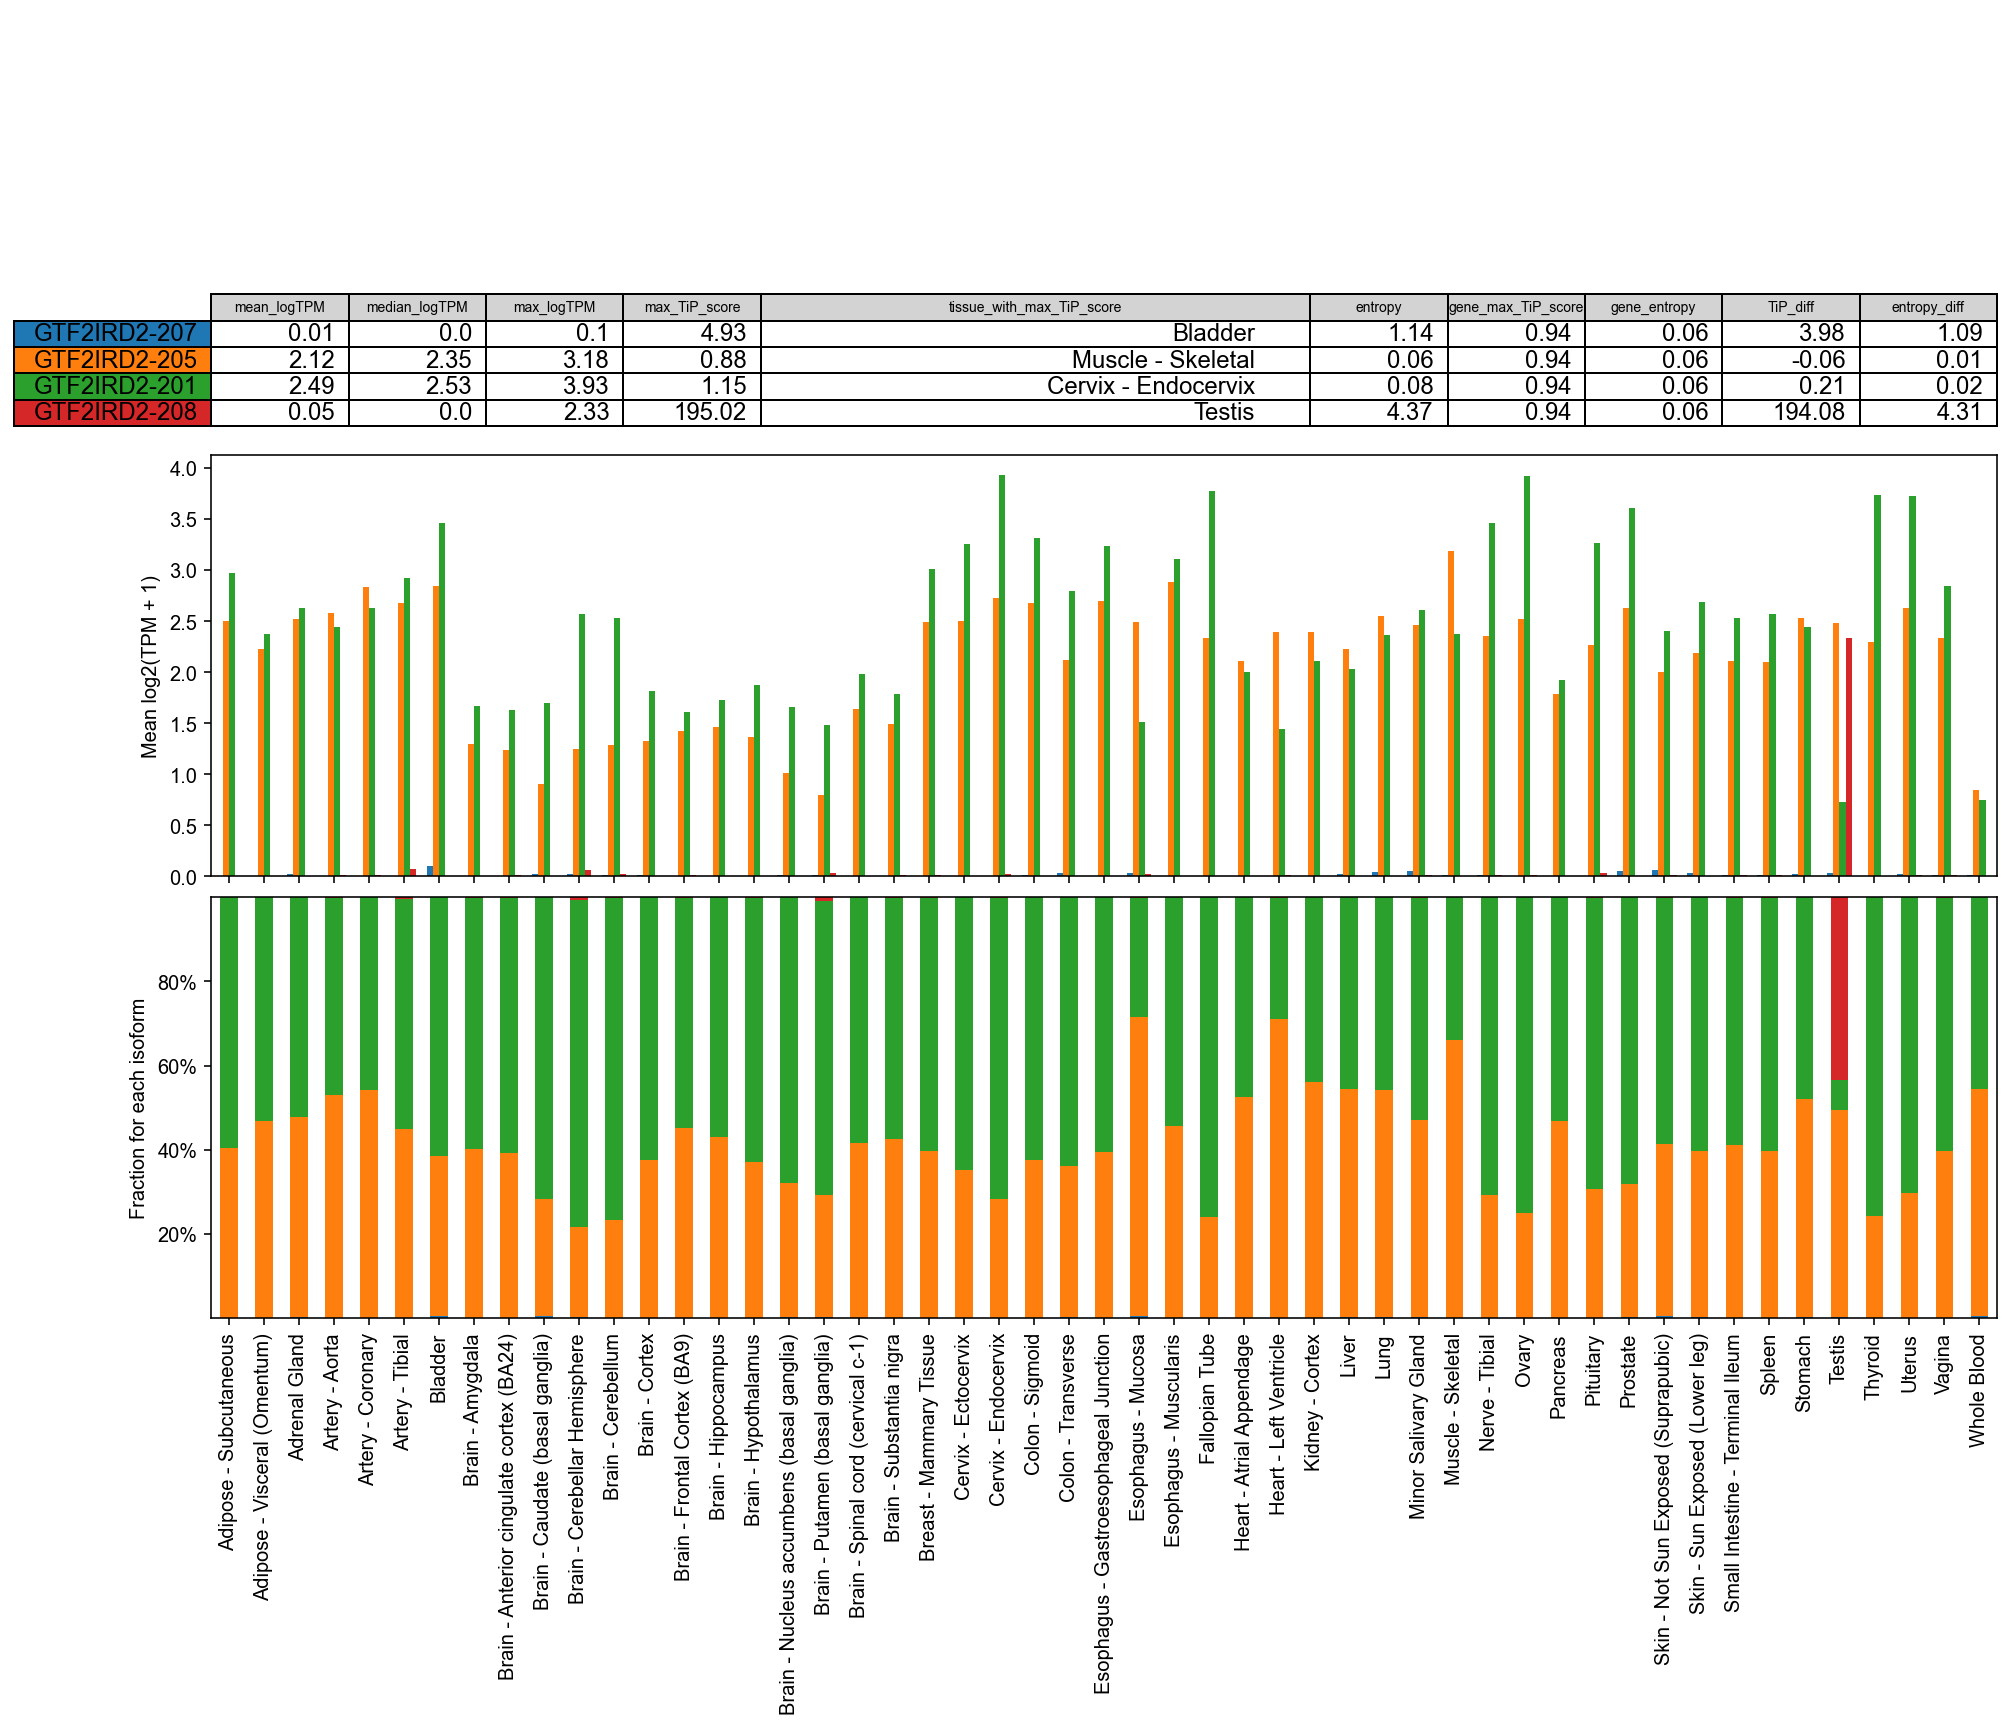

In [31]:
table_and_graphs('GTF2IRD2')

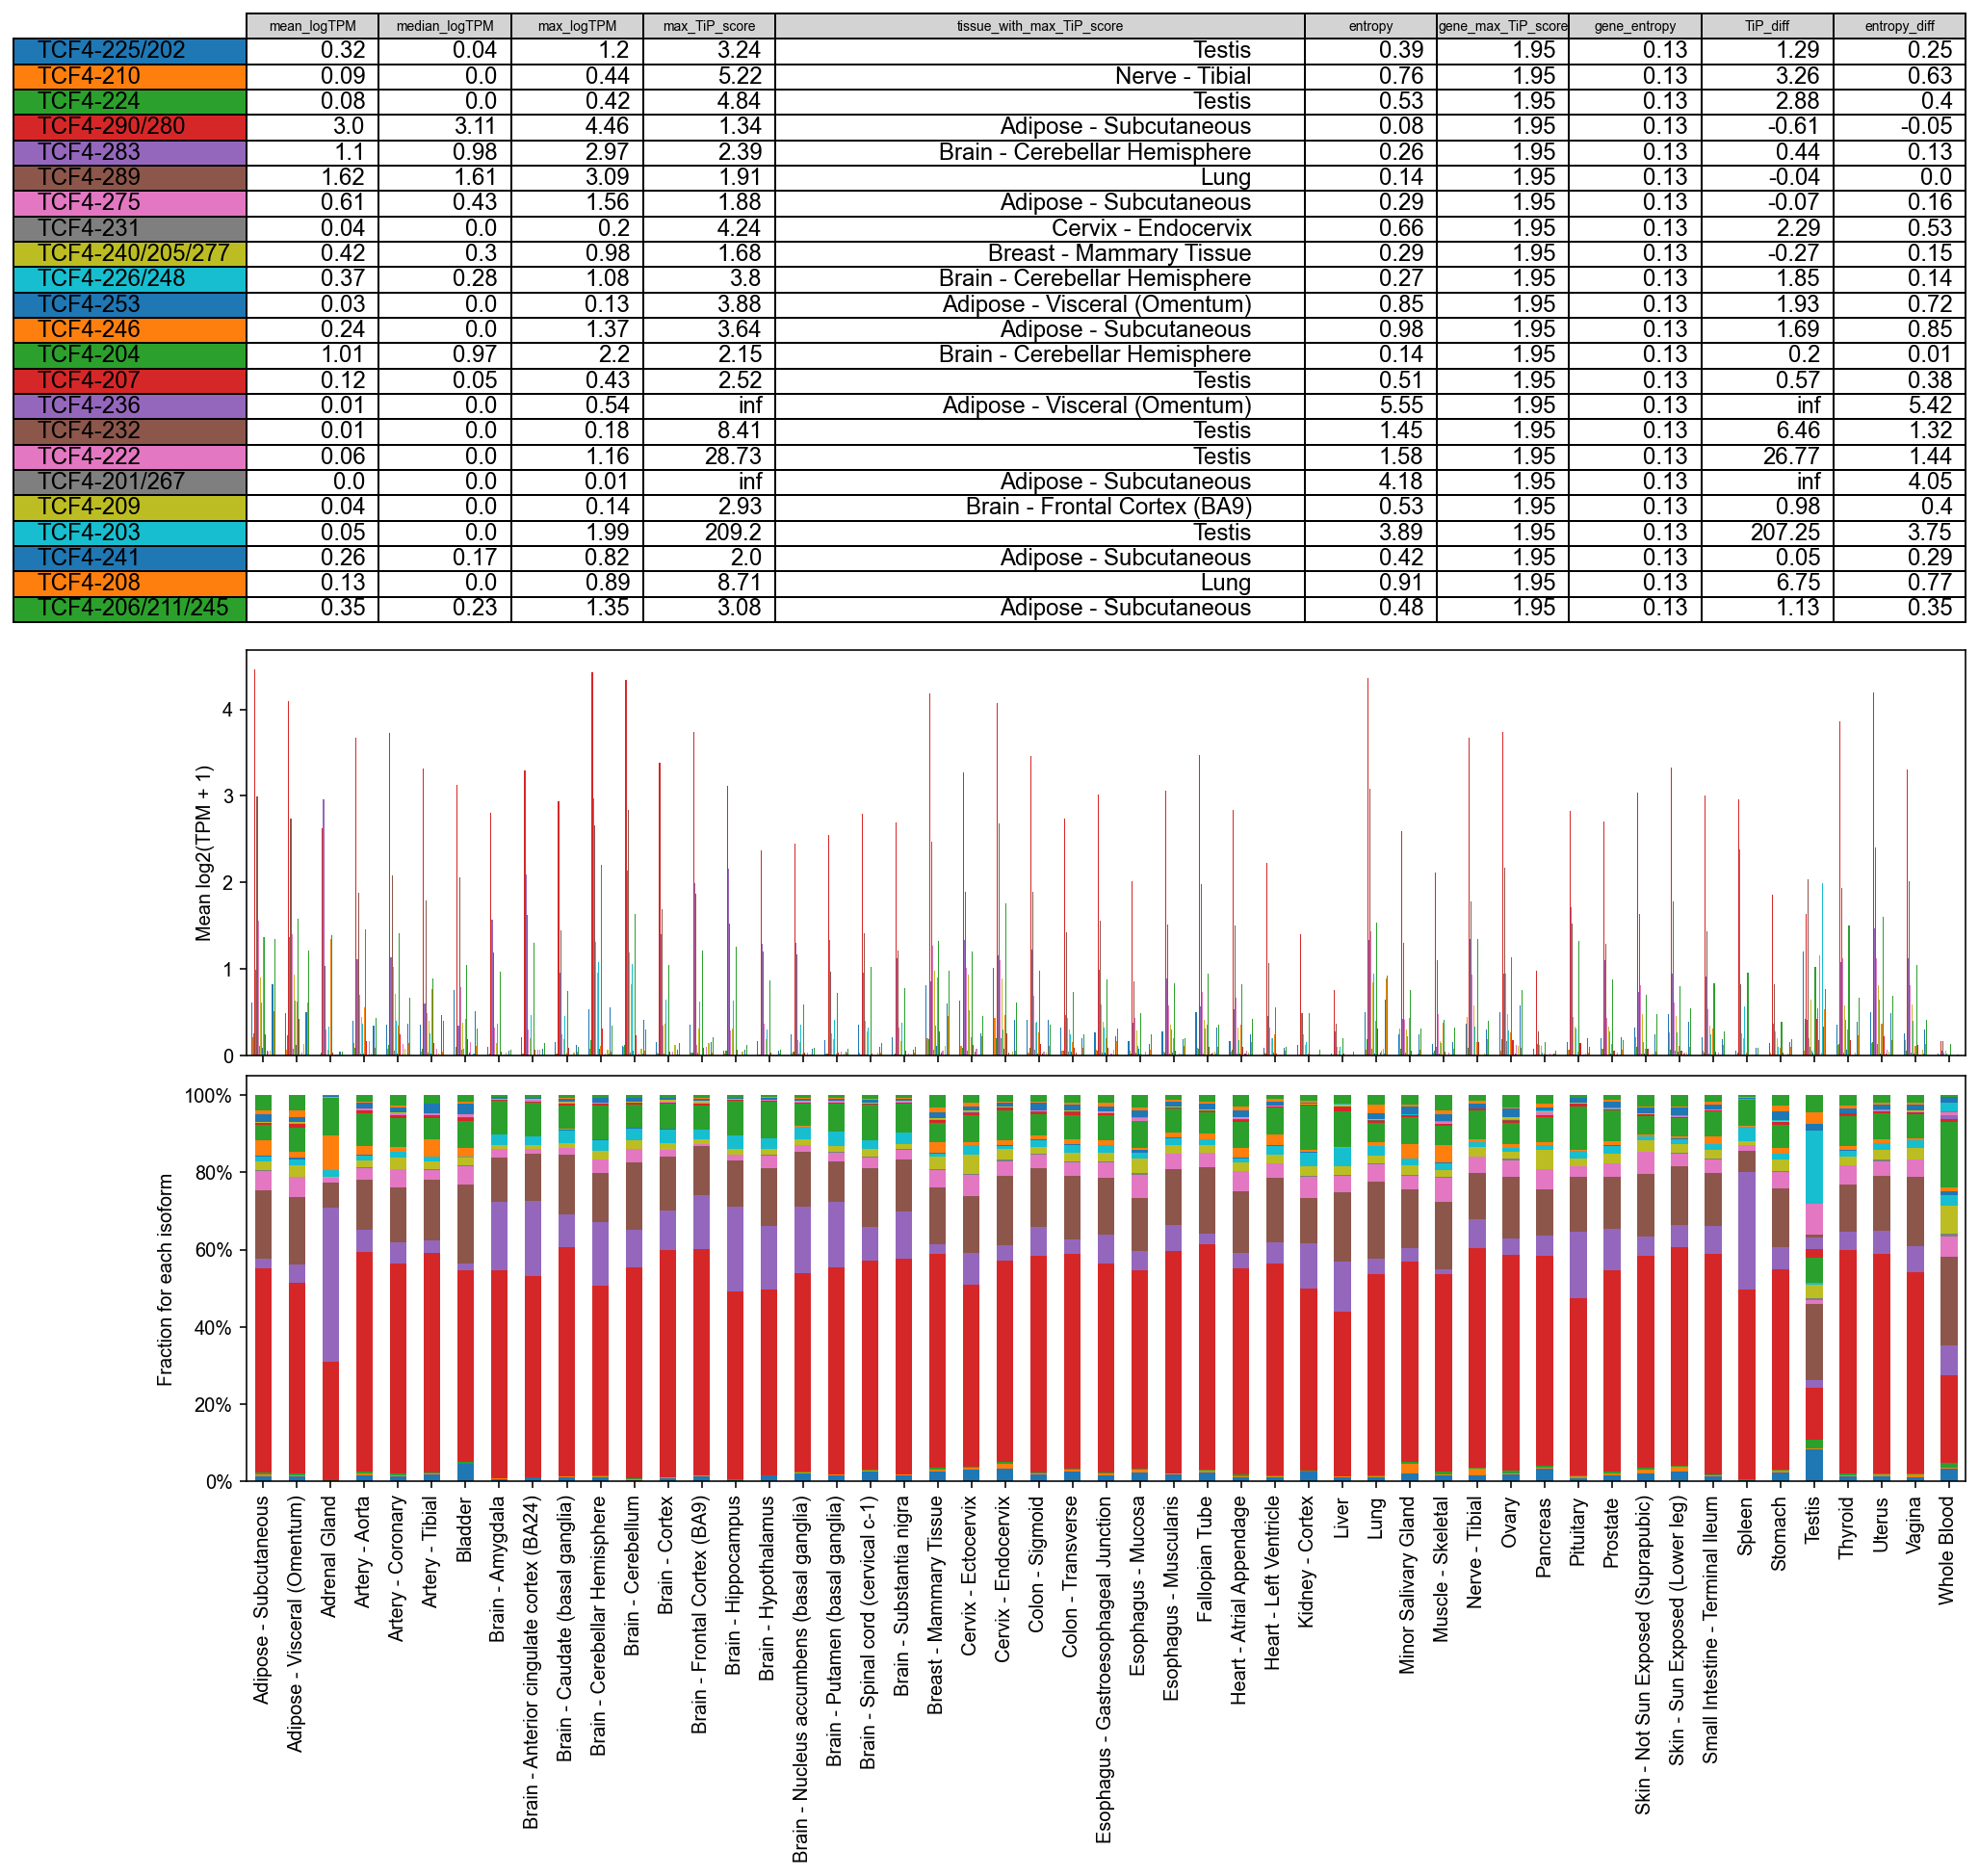

In [33]:
table_and_graphs('TCF4')

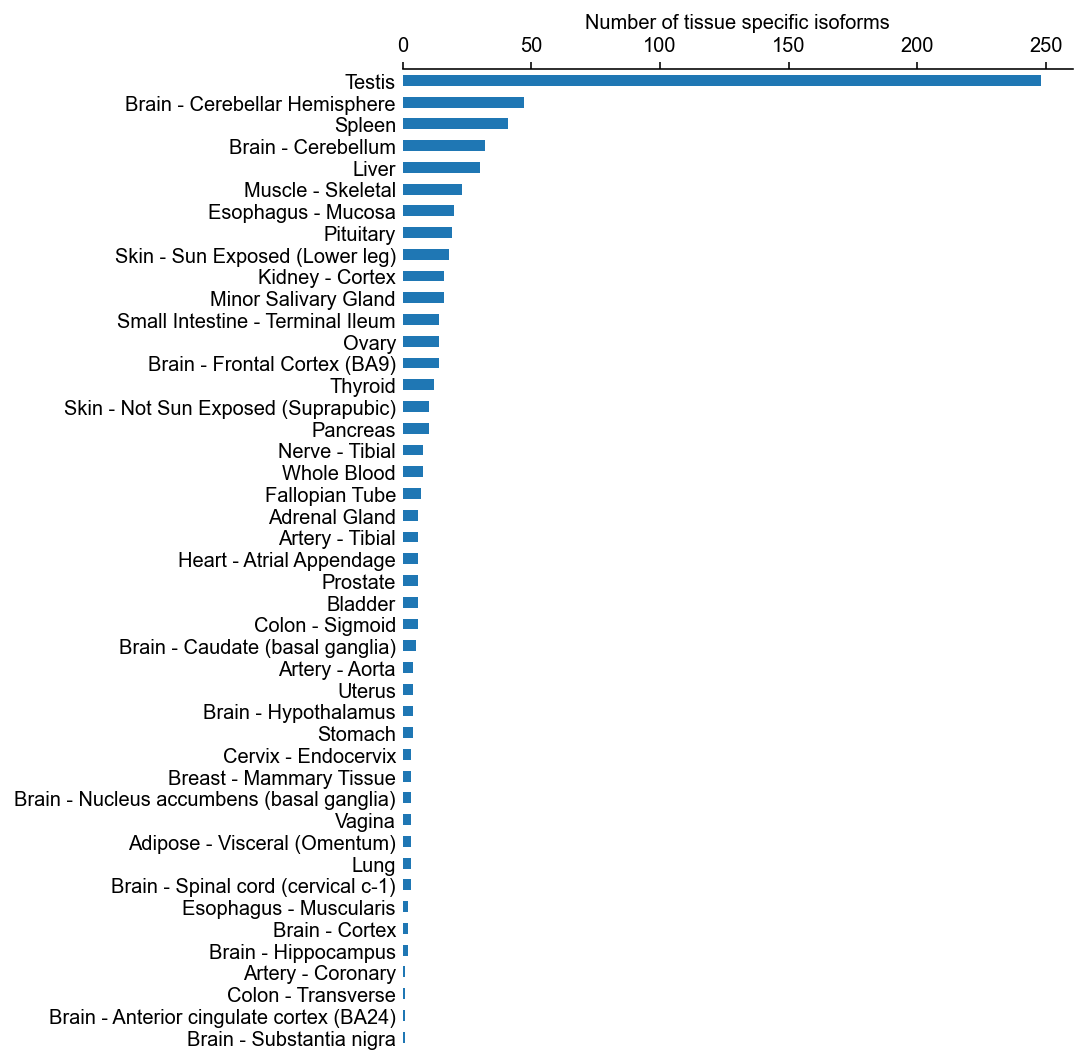

In [34]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 9)
iso.loc[(iso['max_logTPM'] > 1) & (iso['max_TiP_score'] > 5), 'tissue_with_max_TiP_score'].value_counts().plot.barh(ax=ax)
ax.invert_yaxis()
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.set_xlabel('Number of tissue specific isoforms')
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_tick_params(length=0)
plt.savefig('../../figures/number_tissue_specific_isoforms_per_tissue.pdf',
            bbox_inches='tight')

In [42]:
id_map = pd.read_csv('../../data/internal/GTEx-protein-gencode/a_gencode30_uniq_prot_and_annot_sachi_gloria_lambert.tsv',
                     sep='\t')

In [43]:
id_map.head()

orig_gene    new_gene  in_sachi1332  in_gloria1579  in_lambert1639  \
0       SP7  AC073611.1             1              1               1   
1       SP7  AC073611.1             1              1               1   
2       SP7  AC073611.1             1              1               1   
3       SP7  AC073611.1             1              1               1   
4     WHSC1        NSD2             0              1               0   

                 ensg         isoname               enst               ensp  \
0   ENSG00000170374.6  AC073611.1-203  ENST00000537210.2  ENSP00000441367.2   
1   ENSG00000170374.6  AC073611.1-204  ENST00000547755.1  ENSP00000449355.1   
2   ENSG00000170374.6  AC073611.1-202  ENST00000303846.3  ENSP00000302812.3   
3   ENSG00000170374.6  AC073611.1-201  ENST00000536324.4  ENSP00000443827.2   
4  ENSG00000109685.18        NSD2-203  ENST00000382888.3  ENSP00000372344.3   

                                              aa_seq  \
0  MLTAACSKFGGSSPLRDSTTLGKAGTKKPYSVGSDLSASKTMGDAY...   
1  MLTAACSKFGGSSPLRDSTTLGKAGTKKPYSVGSDLSASKTMGDAY...   
2  MASSLLEEEVHYGSSPLAMLTAACSKFGGSSPLRDSTTLGKAGTKK...   
3  MASSLLEEEVHYGSSPLAMLTAACSKFGGSSPLRDSTTLGKAGTKK...   
4  MAGSFCWRMLGLVSKVGNRARCFSSMAASEEELLDFSGSELQFNSC...   

                      same_prot_seq_name  is_repr              appris  \
0                 GC grp: AC073611.1-203        1  appris_secondary_2   
1                 GC grp: AC073611.1-204        1                  na   
2  GC grp: AC073611.1-202|AC073611.1-201        1  appris_principal_3   
3  GC grp: AC073611.1-202|AC073611.1-201        0  appris_principal_3   
4                       GC grp: NSD2-203        1                  na   

   transcript_level  transcript_support_level  isoname_derived_rank  \
0                 1                         1                   203   
1                 2                         3                   204   
2                 2                         1                   202   
3                 2                         2                   201   
4                 2                         1                   203   

   enst_derived_idx  is_basic  is_cds_start_NF  is_cds_end_NF  
0            537210         1                0              0  
1            547755         0                0              1  
2            303846         1                0              0  
3            536324         1                0              0  
4            382888         1                0              0

In [45]:
id_map.loc[id_map['isoname'].str.startswith('RORC'), :]

orig_gene new_gene  in_sachi1332  in_gloria1579  in_lambert1639  \
7241      RORC     RORC             1              1               1   
7242      RORC     RORC             1              1               1   
7243      RORC     RORC             1              1               1   

                    ensg   isoname                enst               ensp  \
7241  ENSG00000143365.18  RORC-208   ENST00000652040.1  ENSP00000498548.1   
7242  ENSG00000143365.18  RORC-201   ENST00000318247.7  ENSP00000327025.6   
7243  ENSG00000143365.18  RORC-202  ENST00000356728.10  ENSP00000349164.6   

                                                 aa_seq same_prot_seq_name  \
7241  MSRDAVKFGRMSKKQRDSLHAEVQKQLQQRQQQQQEPVVKTPPAGA...   GC grp: RORC-208   
7242  MDRAPQRQHRASRELLAAKKTHTSQIEVIPCKICGDKSSGIHYGVI...   GC grp: RORC-201   
7243  MRTQIEVIPCKICGDKSSGIHYGVITCEGCKGFFRRSQRCNAAYSC...   GC grp: RORC-202   

      is_repr              appris  transcript_level  transcript_support_level  \
7241        1                  na                 2                         6   
7242        1  appris_principal_3                 2                         1   
7243        1  appris_secondary_2                 2                         1   

      isoname_derived_rank  enst_derived_idx  is_basic  is_cds_start_NF  \
7241                   208            652040         0                0   
7242                   201            318247         1                0   
7243                   202            356728         1                0   

      is_cds_end_NF  
7241              1  
7242              0  
7243              0

In [51]:
id_map.loc[id_map['isoname'].str.startswith('RORC'), 'aa_seq'].str.len()

7241    176
7242    519
7243    498
Name: aa_seq, dtype: int64

In [48]:
from data_loading import load_valid_isoform_clones
our_iso = load_valid_isoform_clones()

gene       clone_acc                                             aa_seq  \
386  RORC  RORC|2/6|05C10  MRTQIEVIPCKICGDKSSGIHYGVITCEGCKGFFRRSQRCNAAYSC...   
387  RORC  RORC|3/6|12D07  MDRAPQRQHRASRELLAAKKTHTSQIEVIPCKICGDKSSGIHYGVI...   
388  RORC  RORC|4/6|05B09  MRTQIEVIPCKICGDKSSGIHYGVITCEGCKGFFRRSQRCNAAYSC...   

     num_aa  is_novel_isoform  
386     488              True  
387     518             False  
388     497             False

In [57]:
our_iso.loc[our_iso['clone_acc'] == 'RORC|4/6|05B09', 'aa_seq'].values[0]

'MRTQIEVIPCKICGDKSSGIHYGVITCEGCKGFFRRSQRCNAAYSCTRQQNCPIDRTSRNRCQHCRLQKCLALGMSRDAVKFGRMSKKQRDSLHAEVQKQLQQRQQQQQEPVVKTPPAGAQGADTLTYTLGLPDGQLPLGSSPDLPEASACPPGLLKASGSGPSYSNNLAKAGLNGASCHLEYSPERGKAEGRESFYSTGSQLTPDRCGLRFEEHRHPGLGELGQGPDSYGSPSFRSTPEAPYASLTEIEHLVQSVCKSYRETCQLRLEDLLRQRSNIFSREEVTGYQRKSMWEMWERCAHHLTEAIQYVVEFAKRLSGFMELCQNDQIVLLKAGAMEVVLVRMCRAYNADNRTVFFEGKYGGMELFRALGCSELISSIFDFSHSLSALHFSEDEIALYTALVLINAHRPGLQEKRKVEQLQYNLELAFHHHLCKTHRQSILAKLPPKGKLRSLCSQHVERLQIFQHLHPIVVQAAFPPLYKELFSTETESPVGLSK'

In [58]:
id_map.loc[id_map['isoname'] == 'RORC-202', 'aa_seq'].values[0]

'MRTQIEVIPCKICGDKSSGIHYGVITCEGCKGFFRRSQRCNAAYSCTRQQNCPIDRTSRNRCQHCRLQKCLALGMSRDAVKFGRMSKKQRDSLHAEVQKQLQQRQQQQQEPVVKTPPAGAQGADTLTYTLGLPDGQLPLGSSPDLPEASACPPGLLKASGSGPSYSNNLAKAGLNGASCHLEYSPERGKAEGRESFYSTGSQLTPDRCGLRFEEHRHPGLGELGQGPDSYGSPSFRSTPEAPYASLTEIEHLVQSVCKSYRETCQLRLEDLLRQRSNIFSREEVTGYQRKSMWEMWERCAHHLTEAIQYVVEFAKRLSGFMELCQNDQIVLLKAGAMEVVLVRMCRAYNADNRTVFFEGKYGGMELFRALGCSELISSIFDFSHSLSALHFSEDEIALYTALVLINAHRPGLQEKRKVEQLQYNLELAFHHHLCKTHRQSILAKLPPKGKLRSLCSQHVERLQIFQHLHPIVVQAAFPPLYKELFSTETESPVGLSK*'

In [ ]:
# RORC-3 is RORC-201
# RORC-4 is RORC-202

In [11]:
df = pd.read_excel('../../data/processed/gtex_analysis/ANOVA-GC30-basic-MainTissues_ratios-sparse.xlsx')

In [12]:
df.shape

(3479, 4)

In [71]:
(df['ANOVA-adjp'] < 0.05).sum()

3121

In [78]:
df.head()

Probesets  ANOVA-rawp  ANOVA-adjp  largest fold
0   GC grp: KCNIP3-201         0.0         0.0      0.911667
1  GC grp: ZSCAN29-202         0.0         0.0      0.607880
2   GC grp: ZNF207-204         0.0         0.0      0.657803
3   GC grp: ZNF207-201         0.0         0.0      0.518750
4     GC grp: CREM-202         0.0         0.0      0.165000

Text(0.5, 0, 'Largest fold')

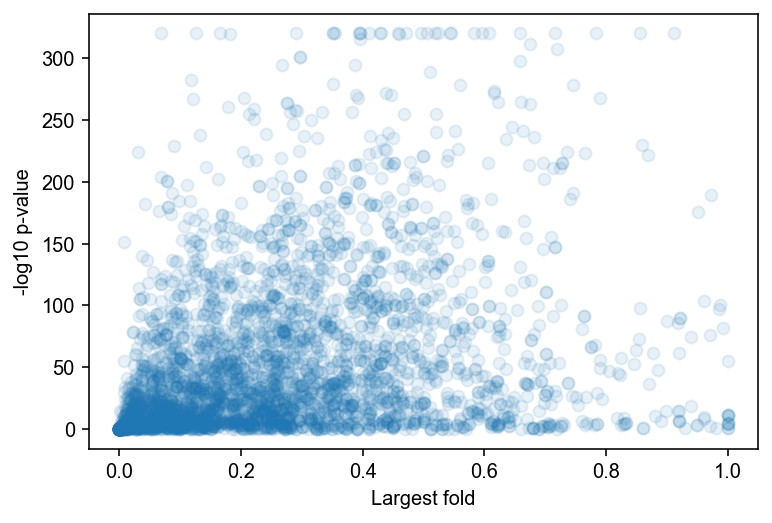

In [106]:
fig, ax = plt.subplots(1, 1)
ax.scatter(df['largest fold'].values,
           - np.log10(df['ANOVA-adjp'].values + np.float64('1E-320')),
           alpha=0.1)
ax.set_ylabel('-log10 p-value')
ax.set_xlabel('Largest fold')

In [96]:
df = pd.read_excel('../../data/processed/gtex_analysis/ANOVA-PSI.xlsx')

In [97]:
df.head()

uid                                                UID  ANOVA-rawp  \
0  ZNF706  ZNF706:ENSG00000120963:E1.2-E6.1|ENSG000001209...         0.0   
1  KCNIP3  KCNIP3:ENSG00000115041:E6.1-E8.1|ENSG000001150...         0.0   
2  KCNIP3  KCNIP3:ENSG00000115041:E5.1-E8.1|ENSG000001150...         0.0   
3   CXXC5  CXXC5:ENSG00000171604:E8.4-E10.1|ENSG000001716...         0.0   
4   CXXC5  CXXC5:ENSG00000171604:E8.4-E9.2|ENSG0000017160...         0.0   

   ANOVA-adjp      dPSI  
0         0.0  0.185663  
1         0.0  0.978156  
2         0.0  0.954040  
3         0.0  0.293297  
4         0.0  0.328706

In [98]:
(df['ANOVA-adjp'] < 0.05).sum()

9030

In [99]:
df.shape

(10981, 5)

Text(0.5, 0, 'dPSI')

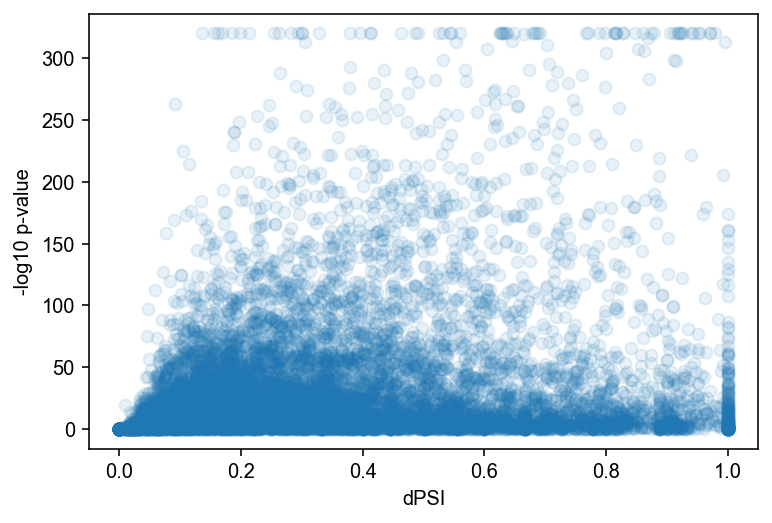

In [103]:
fig, ax = plt.subplots(1, 1)
ax.scatter(df['dPSI'].values,
           - np.log10(df['ANOVA-adjp'].values + np.float64('1E-320')),
           alpha=0.1)
ax.set_ylabel('-log10 p-value')
ax.set_xlabel('dPSI')